# TOP BOTTOM - CHURN PROJECT

# Ciclo 00 - Metodo IOT

## Input

### O problema de negócio

1. Recorrencia de compra baixa.
2. Clientes deixando de comprar apos determinado periodo.

## Output

1. Qual a taxa de Churn atual da empresa?
2. Como a taxa de churn varia por mes?
3. Qual retorno esperado em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn?
4. Qual a performance do modelo em classificar os clientes como churns?



## Tasks

1. Qual a taxa de Churn atual da empresa?
    - Anual, semestral ou mensal.
    - Se 1 de cada 20 clientes cancelam seu produto todo mês, isso representa que a taxa de churn para seu produto será de 5%.
    - Encontrar churn rate e fazer o churn mensal.

2. Como a taxa de churn varia por mes?
    - Calcular o churn mensal.
    - MRR CHURN = SUM (MRR dos clientes cancelados)

3.Qual retorno esperado em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn?
 - se esse cliente for recuperado quanto ele me traz baseado no salario
     - threshold
     - lista de pessoas que vao entrar em churn ordenada
     - quais pessoas recuperar
     - LTV
     - curva Roc (live 21)

4. Qual a performance do modelo em classificar os clientes como churns?
    - Mostrar Recall, Precision e Acc.
    - Procurar diferentes metricas de reporte.
    - fazer o score



## Etapa 01 - Descrição dos dados: 
   - O objetivo é utilizar métricas estatísticas para identificar outliers no escopo do negócio.

## Etapa 02 - Feature Engineering:
   - Derivar novos atributos com base nas variáveis ​​originais para melhor descrever o fenômeno a ser modelado.

## Etapa 03 - Filtragem de Dados: 
- Filtrar as linhas e selecione as colunas que não contenham informações para modelagem ou que não correspondam ao escopo do negócio.

## Etapa 04 - Análise Exploratória de Dados: 
- Explorar os dados para encontrar insights e entender melhor o impacto das variáveis ​​no aprendizado do modelo.

## Etapa 05 - Preparação de dados: 
- Preparar os dados para que os modelos de aprendizado de máquina possam aprender comportamentos específicos.

## Etapa 06 - Seleção de atributos: 
- Seleção dos atributos mais significativos para treinar o modelo.

## Etapa 07 - Machine Learning Modeling: 
-Treinamento do modelo de aprendizado de máquina

## Passo 08 -  Hyperparameter Fine Tunning:
- Escolha os melhores valores para cada um dos parâmetros do modelo selecionado no passo anterior.

## Etapa 09 - Converter o desempenho do modelo em valores de negócios: 
- Converter o desempenho do modelo em resultado de negócios.

## Etapa 10 - Implantar o modelo na produção: 
- Publique o modelo em um ambiente de nuvem para que outras pessoas ou serviços possam usar os resultados para melhorar a decisão de negócios.

# 0.0 IMPORTS

In [1]:
import shap 
import pickle
import warnings
import inflection

import pandas                  as pd
import numpy                   as np
import seaborn                 as sns
import matplotlib              as plt

from yellowbrick.classifier    import  ConfusionMatrix
from IPython.core.display      import HTML
from sklearn                   import preprocessing
from sklearn.preprocessing     import RobustScaler,StandardScaler, MinMaxScaler
from sklearn                   import model_selection    as ms
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LogisticRegression

from boruta                    import BorutaPy
from BorutaShap                import BorutaShap
from scipy.stats               import chi2_contingency,shapiro
from sklearn.metrics           import accuracy_score, classification_report


from imblearn                  import under_sampling as us
from imblearn                  import over_sampling  as oversamp
from imblearn                  import combine        as c
from imblearn.over_sampling    import KMeansSMOTE as ksmt
from catboost                  import CatBoostClassifier, Pool





##  Helper Functions

In [2]:


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()
warnings.filterwarnings("ignore")


#Function to plot correlation of a column 
def plot_corr(col):
    a = correlation[col].sort_values(ascending=False).to_frame()
    a.columns = ['']
    a.drop(col, axis=0, inplace=True)
    plot = sns.heatmap( a, annot=True, cmap='Greens').set_title(col);
    
    return plot

# cramer V function to calculate correlation btw categorical variables
def cramer_v(x, y):
    # Confusion Matrix
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


##  Get Data from Database

##  Load dataset

In [3]:
df_raw=pd.read_csv('/home/tc0019/DS/topbottom/churn.csv')
df_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#  1.0 DESCRICAO DOS DADOS

In [4]:
df1=df_raw.copy()

## 1.1. Rename Columns

All columns will be renamed to snake case: https://en.wikipedia.org/wiki/Snake_case.

The main objective is create a columns name pattern to make simple dealing with the dataset.

In [5]:
df1.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [6]:
cols_old=['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print( f'Number of Rows: {df1.shape[0]}')
print( f'Number of Columns: {df1.shape[1]}')

Number of Rows: 10000
Number of Columns: 14


## 1.3. Data Types

In [8]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

In [9]:
df1.tail()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


## 1.4. Check NA

 The dataset has no occurrence of NAs

In [10]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5. Descriptive Statistics

In [11]:
df1_num=df1.select_dtypes(include=['int64', 'float64'])
df1_cat=df1.select_dtypes(exclude=['int64', 'float64', 'datetime'])

### 1.5.1. Numerical Atributes

In [12]:
# Central Tendency - mean, meadina
ct1= pd.DataFrame(df1_num.apply(np.mean)).T
ct2= pd.DataFrame(df1_num.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
ct3= pd.DataFrame(df1_num.apply(np.std)).T
ct4= pd.DataFrame(df1_num.apply(min)).T
ct5= pd.DataFrame(df1_num.apply(max)).T
ct6= pd.DataFrame(df1_num.apply(lambda x: x.max() - x.min())).T
ct7= pd.DataFrame(df1_num.apply(lambda x: x.skew())).T
ct8= pd.DataFrame(df1_num.apply(lambda x: x.kurtosis())).T
ct9 = pd.DataFrame(df1_num.apply(lambda x: 'not normal' if shapiro(x.sample(5000))[1] < 0.05 else 'normal')).T


# concatenar
df_statistics= pd.concat([ct4, ct5, ct6, ct1, ct2,ct3, ct7, ct8, ct9]).T
df_statistics.columns=['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'shapiro']
df_statistics.round(2)

,min,max,range,mean,median,std,skew,kurtosis,shapiro
row_number,1.0,10000.0,9999.0,5000.5,5000.5,2886.751332,0.0,-1.2,not normal
customer_id,15565701.0,15815690.0,249989.0,15690940.5694,15690738.0,71932.589224,0.001149,-1.196113,not normal
credit_score,350.0,850.0,500.0,650.5288,652.0,96.648466,-0.071607,-0.425726,not normal
age,18.0,92.0,74.0,38.9218,37.0,10.487282,1.01132,1.395347,not normal
tenure,0.0,10.0,10.0,5.0128,5.0,2.89203,0.010991,-1.165225,not normal
balance,0.0,250898.09,250898.09,76485.889288,97198.54,62394.285254,-0.141109,-1.489412,not normal
num_of_products,1.0,4.0,3.0,1.5302,1.0,0.581625,0.745568,0.582981,not normal
has_cr_card,0.0,1.0,1.0,0.7055,1.0,0.455818,-0.901812,-1.186973,not normal
is_active_member,0.0,1.0,1.0,0.5151,1.0,0.499772,-0.060437,-1.996747,not normal
estimated_salary,11.58,199992.48,199980.9,100090.239881,100193.915,57507.617221,0.002085,-1.181518,not normal


**Relavants Observations:**

**credit_score** may be better work in a categorical way to group people in classes

**estimated_salary** will be considered as annual salary, the value 11.50 must be checked it may be an input error.

**none** of the features have normal distribution

### 1.5.2 Categorical Attributes

**Gender** do not show to be a significant attribute to consider churn

**Geography** has similar churn, nothing seems to extrapolate due geo.

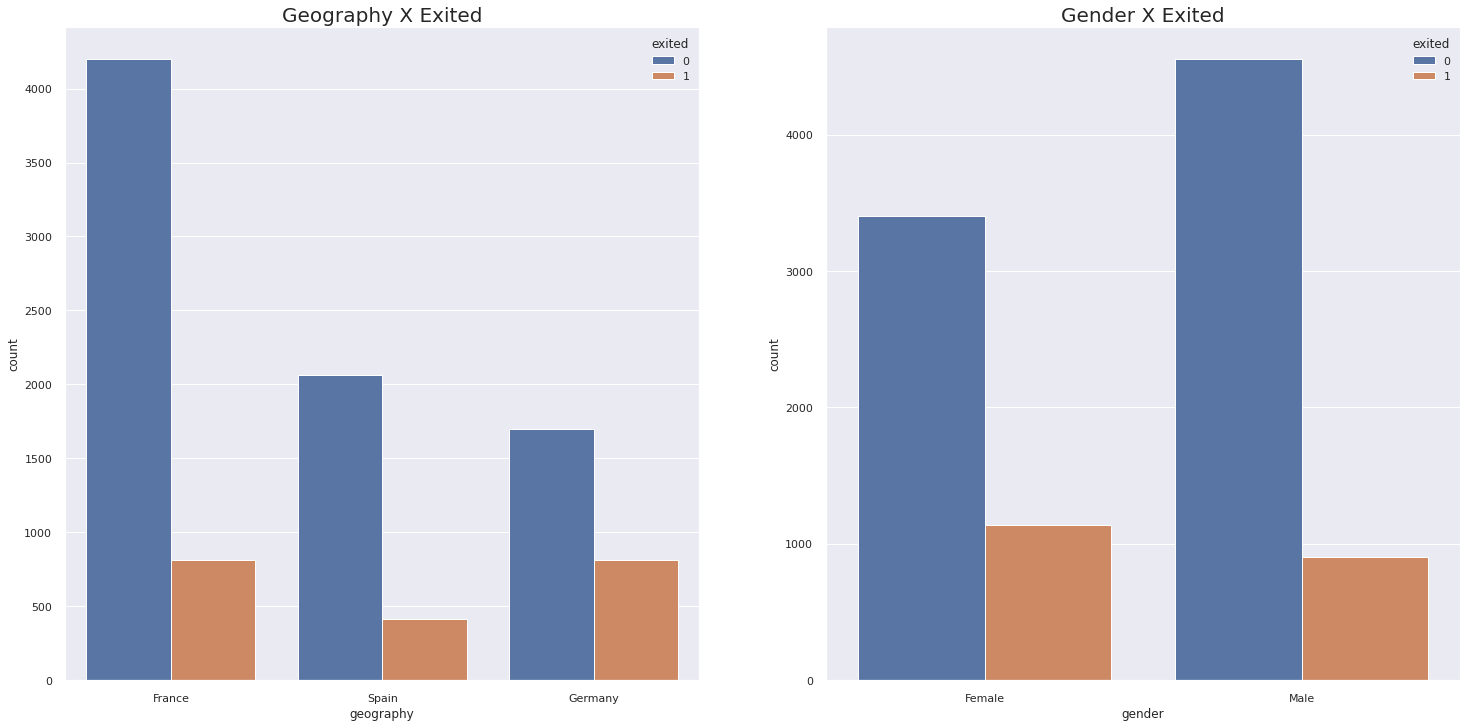

In [13]:
plt.subplot(1,2,1)
sns.countplot(x='geography', hue='exited', data=df1).set_title('Geography X Exited', fontsize=20);

plt.subplot(1,2,2)
sns.countplot(x='gender', hue='exited', data=df1).set_title('Gender X Exited', fontsize=20);



### 1.5.3 Target Variable

The dataset is unbalanced. Smote Tomek may be used here.

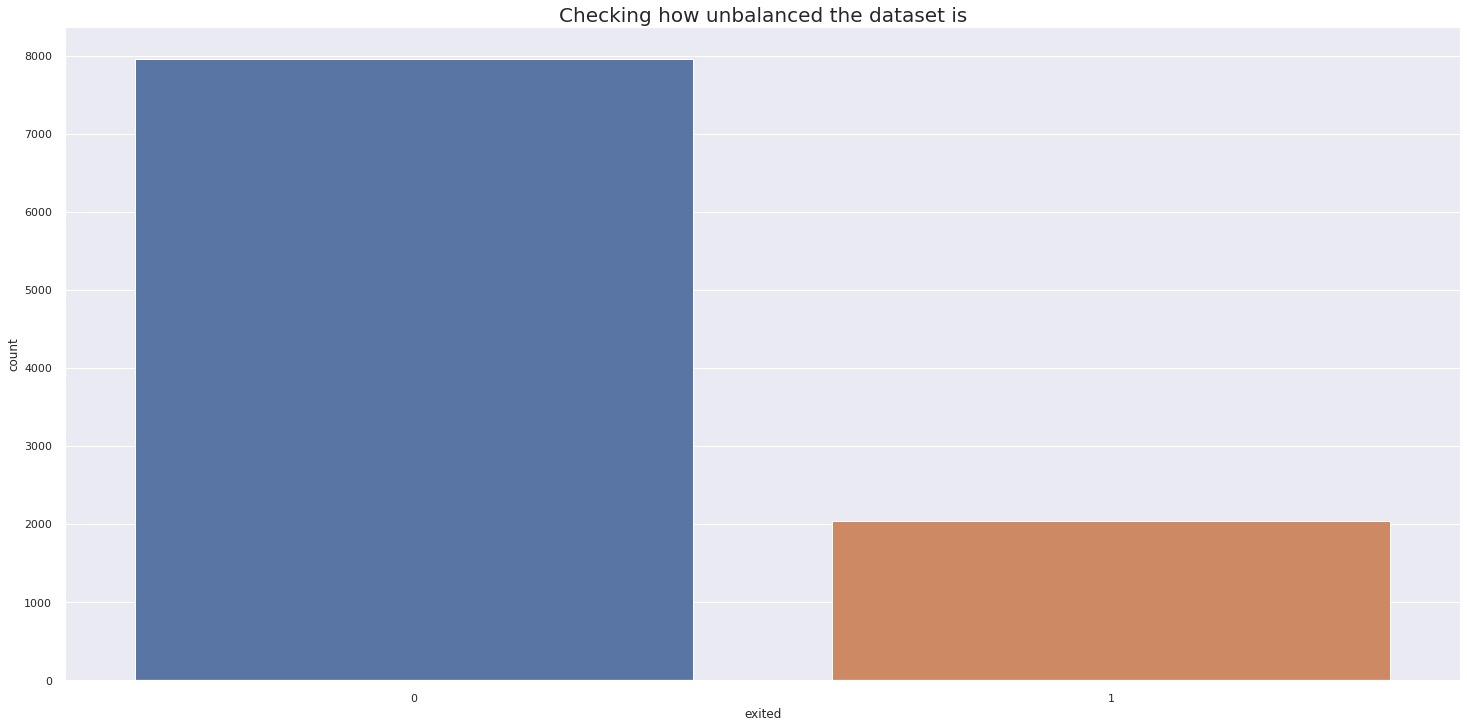

In [14]:
sns.countplot(x='exited', data=df1).set_title('Checking how unbalanced the dataset is', fontsize=20);

# 2.0 FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1 Hypothesis Mental Map

###  2.1.1 Hypotheses List

1. Os usuarios com score maior que 800 tem mais dinheiro em media. 
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.
7. Os clientes com cadastro ativo sao maioria mulheres. 
8. Os clientes com maior numero de tenure comprados sao os que tem o menor salario estiamdo.
9. Pessoas que possuem cartao sao mais ativas do que as que nao possuem mais.
10. Salarios acima de 80k permanecem em media 3 anos.
11. Os alemaes possuem o maior salario da base.
12. Pessoas com balancos superior a 70k sao menos propensas ao churn.
13. Pessoas com score superior a 780 nao deixam a empresa.
14. Pessoas da franca entram sao mais propensos a entrar em churn do que as demais.
15. Homens entram em churn mais do que mulheres.
16. Pessoas acima dos 35 sao mais propensas a sairem da empresa.
17. Homens acima 40 anos e sem atividade no site sao mais propensos ao churn.
18. Mulheres abaixo dos 30 anos tem 70% de chance de NAO abandonar a empresa.
19. Homens com 40 anos e sem atividade no site sao mais propensos ao churn.
20. Mulheres com score acima dos 800 e balance acima de 80k tem 90% de NAO abandonar a empresa.
21. Pessoas com tenure acima de 8 tem 60% de pessoas ativa no site.



###  2.1.2 Hypotheses Final List

1. Os usuarios com score maior que 800 em media tem mais dinheiro no banco.
2. A espanha possue o maior numero de cartoes de credito da base de dados.
3. O publico feminino possui o score maior do que o masculino. 
4. Homens possuem mais dinheiro do que mulheres no banco.
5. O salario estimados das mulherem em media eh maior do que dos homens.
6. Pessoas que moram na alemanha em media sao mais ativos que os demais.


## 2.2 Feature Engineering

In [16]:
# df2['credit_score']=df2['credit_score'].apply(lambda x: 'poor' if x <=200 else
#                                                         'fair' if x in range(201, 400) else
#                                                         'good' if x in range(401, 600) else
#                                                         'great' if x in range(601, 800)
#                                                         else 'awesome'
#                                                          )


df2['balance_by_age']=df2['balance']/df2['age']
df2['num_of_prod_by_age']=df2['num_of_products']/df2['age']
df2['balance_by_num_of_prod']=df2['balance']/df2['num_of_products']

df2.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_by_age,num_of_prod_by_age,balance_by_num_of_prod
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.023810,0.000000
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2044.094146,0.024390,83807.860000
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3801.447619,0.071429,53220.266667
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.051282,0.000000
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2918.856279,0.023256,125510.820000


#  3.0 FILTRAGEM DE VARIÁVEIS

 Some variables won't be useful understanding the dataset nor to create the machine learning model, then we will remove it.


In [17]:
df3 = df2.copy()

cols_drop = ['row_number','customer_id','surname']
df3 = df3.drop(cols_drop, axis=1)

In [18]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_by_age,num_of_prod_by_age,balance_by_num_of_prod
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.023810,0.000000
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2044.094146,0.024390,83807.860000
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3801.447619,0.071429,53220.266667
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.051282,0.000000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2918.856279,0.023256,125510.820000


In [19]:
# take a look in these customers
df3[df3['balance']==0.00].shape[0]


3617

# 4.0 ANALISE EXPLORATORIA DOS DADOS

In [20]:
df4 = df3.copy()

In [21]:
df4.dtypes

credit_score                int64
geography                  object
gender                     object
age                         int64
tenure                      int64
balance                   float64
num_of_products             int64
has_cr_card                 int64
is_active_member            int64
estimated_salary          float64
exited                      int64
balance_by_age            float64
num_of_prod_by_age        float64
balance_by_num_of_prod    float64
dtype: object

In [22]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,balance_by_age,num_of_prod_by_age,balance_by_num_of_prod
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.023810,0.000000
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,2044.094146,0.024390,83807.860000
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,3801.447619,0.071429,53220.266667
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.051282,0.000000
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,2918.856279,0.023256,125510.820000


## 4.1. Analise Univariada
plot always distplot e boxplot with plt subplot, and make observation

### 4.1.1 Credit Score
- Even though this feature seems to be a normal distribuiton in shapiro test earlier showed not normal.

- A normalization can be tested (Standardization can become skewed or biased if the input variable contains outlier values.)

- To overcome this, the median and interquartile range can be used when standardizing numerical input variables, generally referred to as robust scaling.

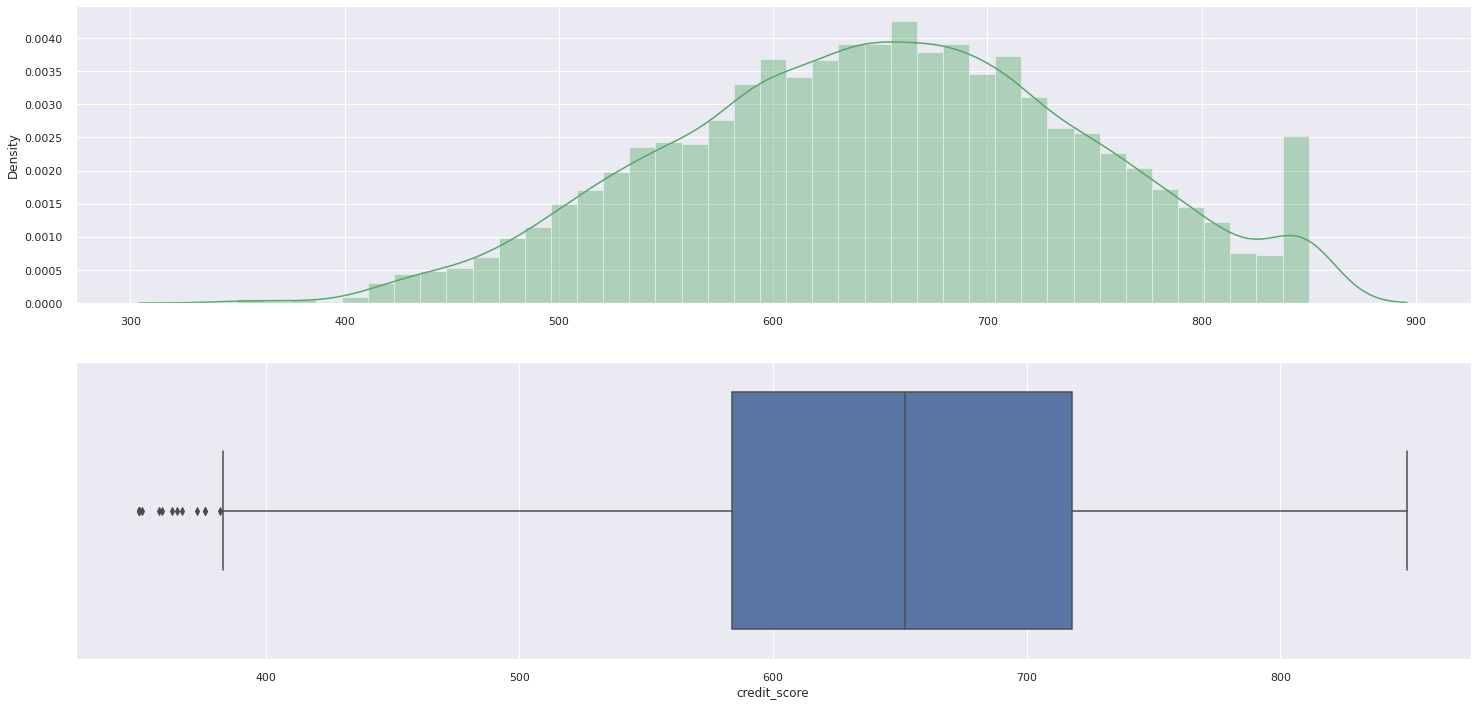

In [23]:
plt.subplot(2,1,1)
sns.set_color_codes()
sns.distplot(x=df1['credit_score'], color='g');

plt.subplot(2,1,2)
sns.boxplot(x=df1['credit_score']);


### 4.1.2 Geography

- Geo must have a closer look when comparade to exited.

- France can cause an unbalance in target

- Analysis done on topic 1.5.2 with the conclusion: churn isnt attached to geo

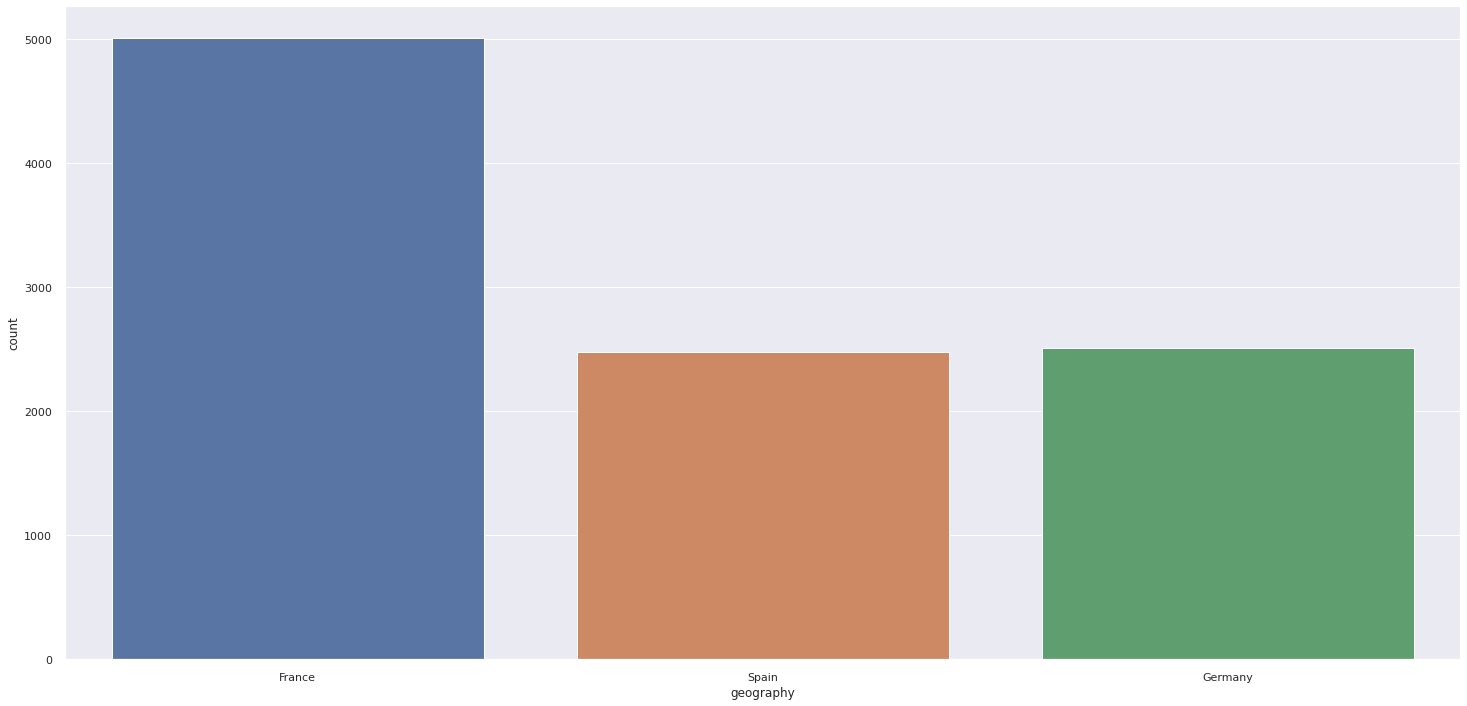

In [24]:

x=df4['geography']

sns.countplot(x=x);

### 4.1.3 Gender

- **Gender** do not show to be a significant attribute to consider churn
- Men give slightly more churn than women.

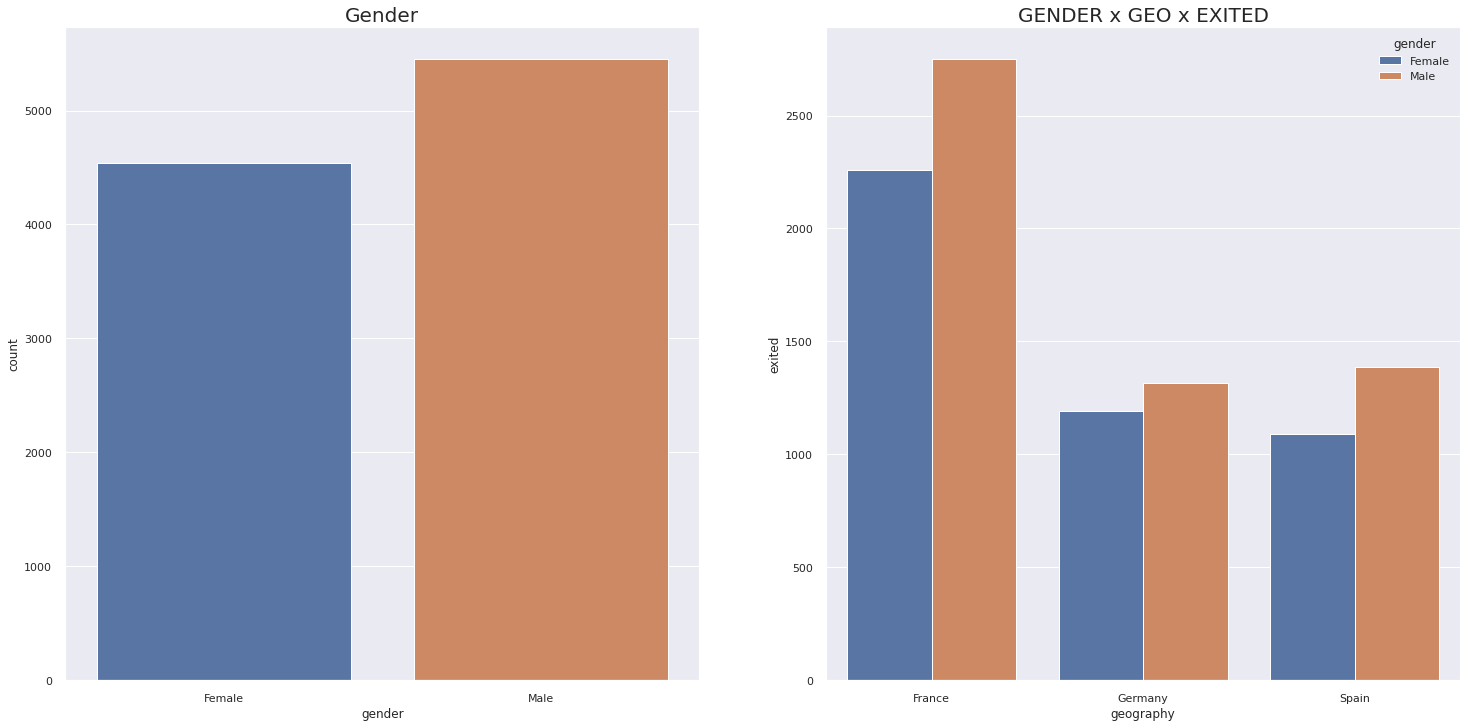

In [25]:
plt.subplot(1,2,1)
x=df4['gender']
sns.countplot(x=x).set_title('Gender', fontsize=20);


plt.subplot(1,2,2)
auxgen=df4[['geography', 'gender', 'exited']].groupby(['geography','gender']).count().reset_index()
sns.barplot(x = 'geography', hue= 'gender', y = 'exited', data=auxgen).set_title('GENDER x GEO x EXITED', fontsize=20);

### 4.1.4 Age
- It's notorious that older clients tend to churn more.
- The most common age is 37.

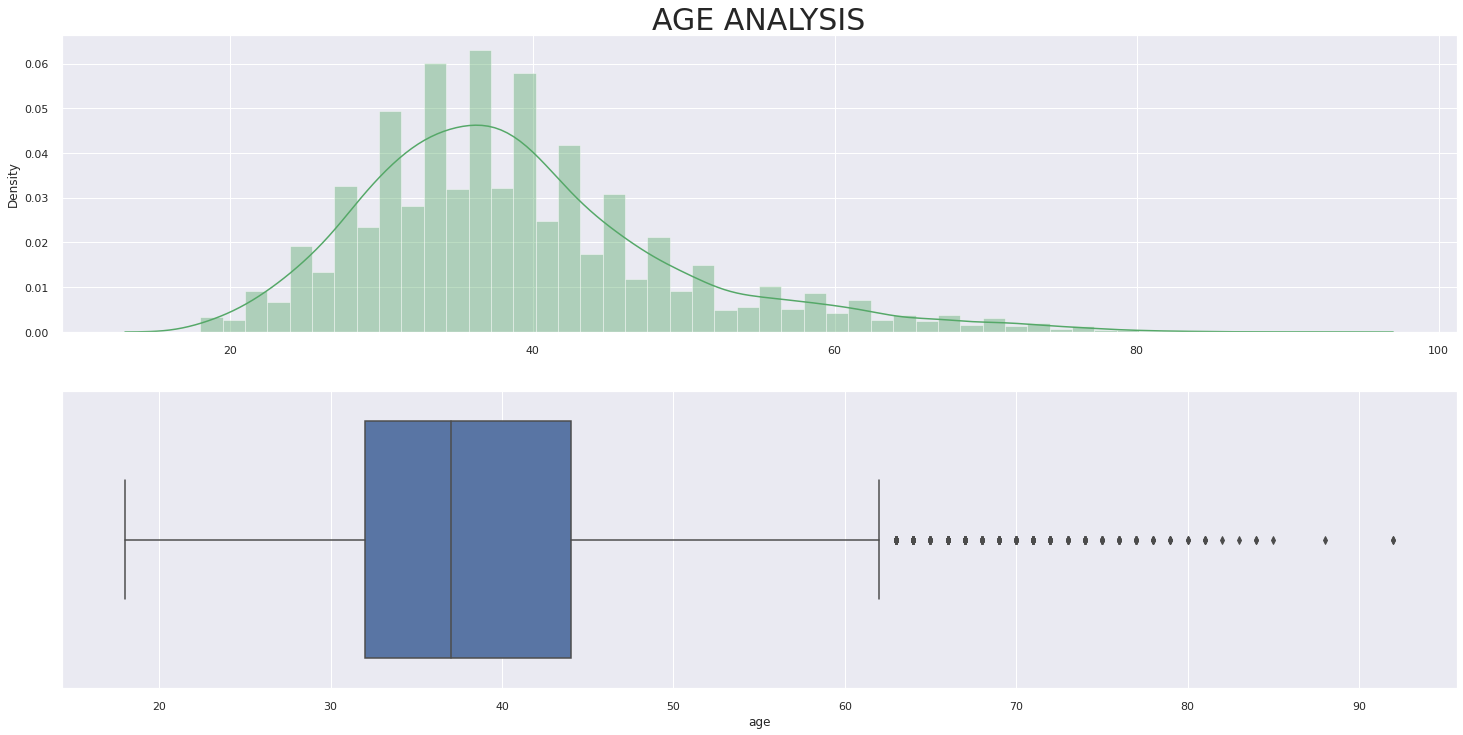

In [26]:
plt.subplot(2,1,1)
sns.set_color_codes()
sns.distplot(x=df1['age'], color='g').set_title('AGE ANALYSIS', fontsize=30);

plt.subplot(2,1,2)
sns.boxplot(x=df4['age']);

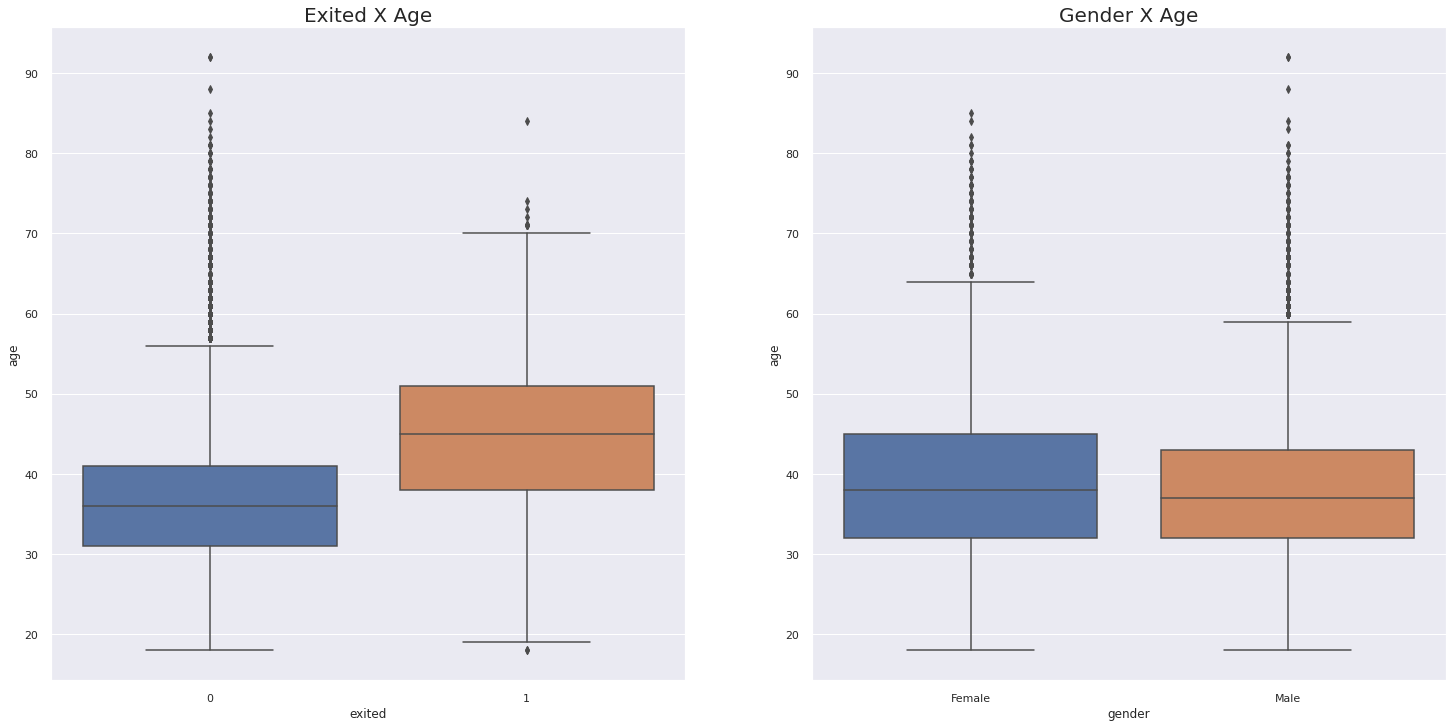

In [27]:
plt.subplot(1,2,1)
sns.boxplot(x='exited', y='age', data=df4).set_title('Exited X Age', fontsize=20);

plt.subplot(1,2,2)
sns.boxplot(x='gender', y='age', data=df4).set_title('Gender X Age', fontsize=20);


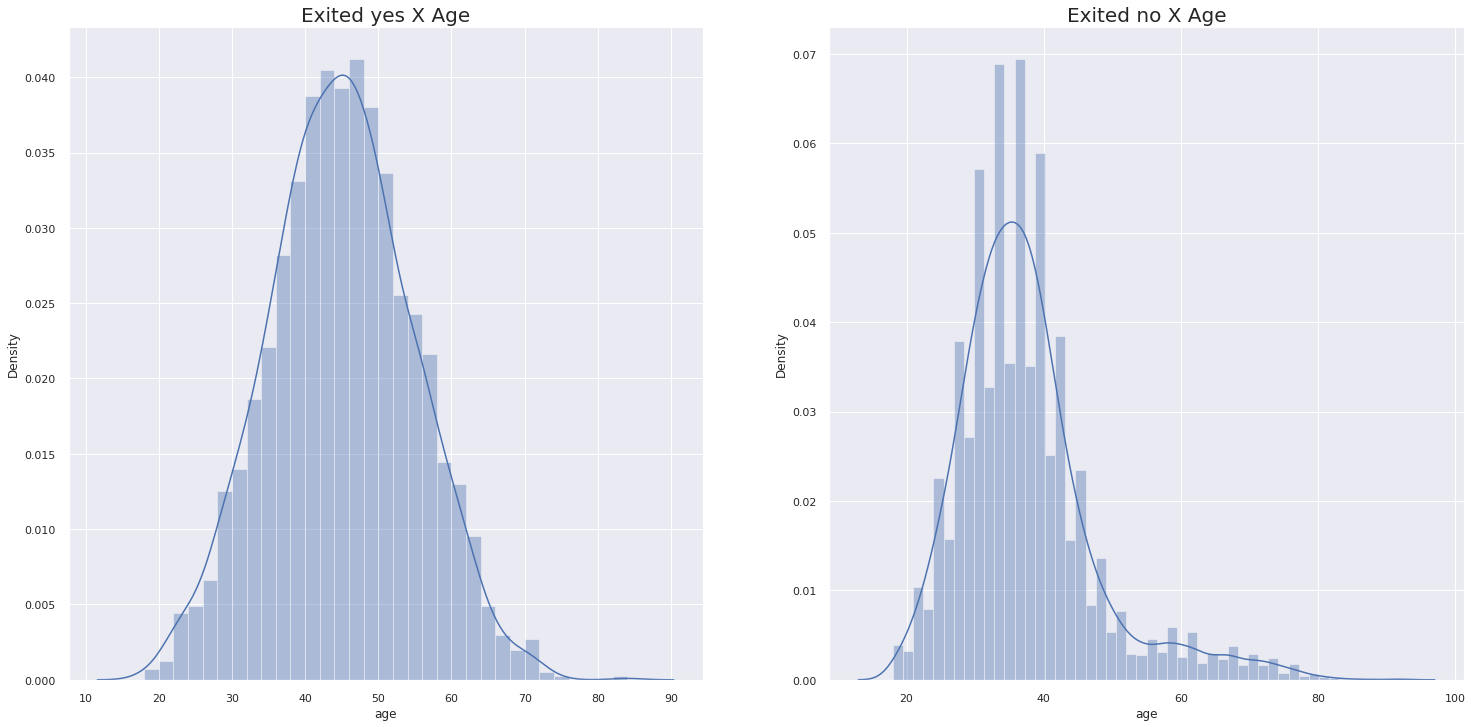

In [28]:
plt.subplot(1,2,1)
aux=df4.loc[df4['exited']==1,'age']
sns.distplot(aux).set_title('Exited yes X Age', fontsize=20);

plt.subplot(1,2,2)
aux1=df4.loc[df4['exited']==0, 'age']
sns.distplot(aux1).set_title('Exited no X Age', fontsize=20);

### 4.1.5 Tenure

- It has a unitary distribution

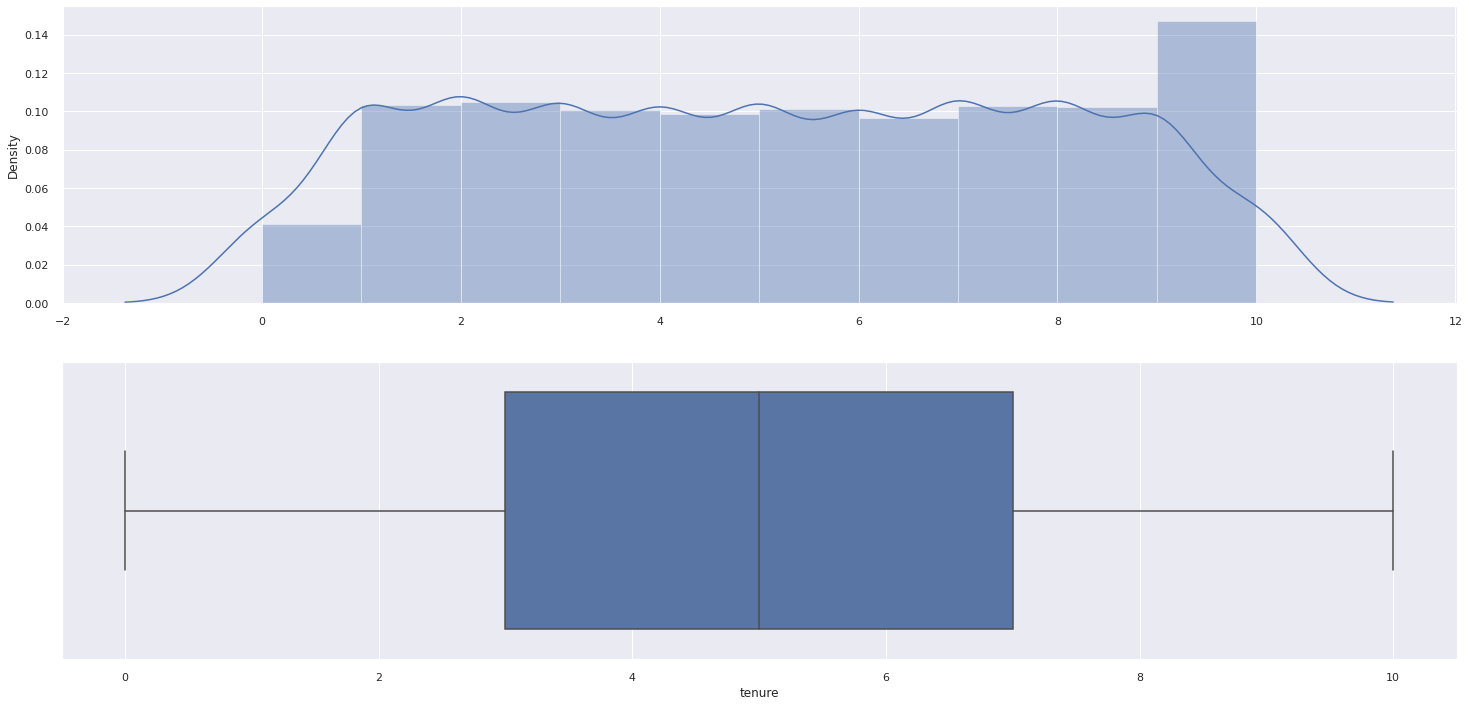

In [29]:
plt.subplot(2,1,1);
sns.distplot(x=df1['tenure'], bins=10);

plt.subplot(2,1,2);
sns.boxplot(x='tenure', data=df4);


### 4.1.6 Estimated Salary
- It has a unitary distribution

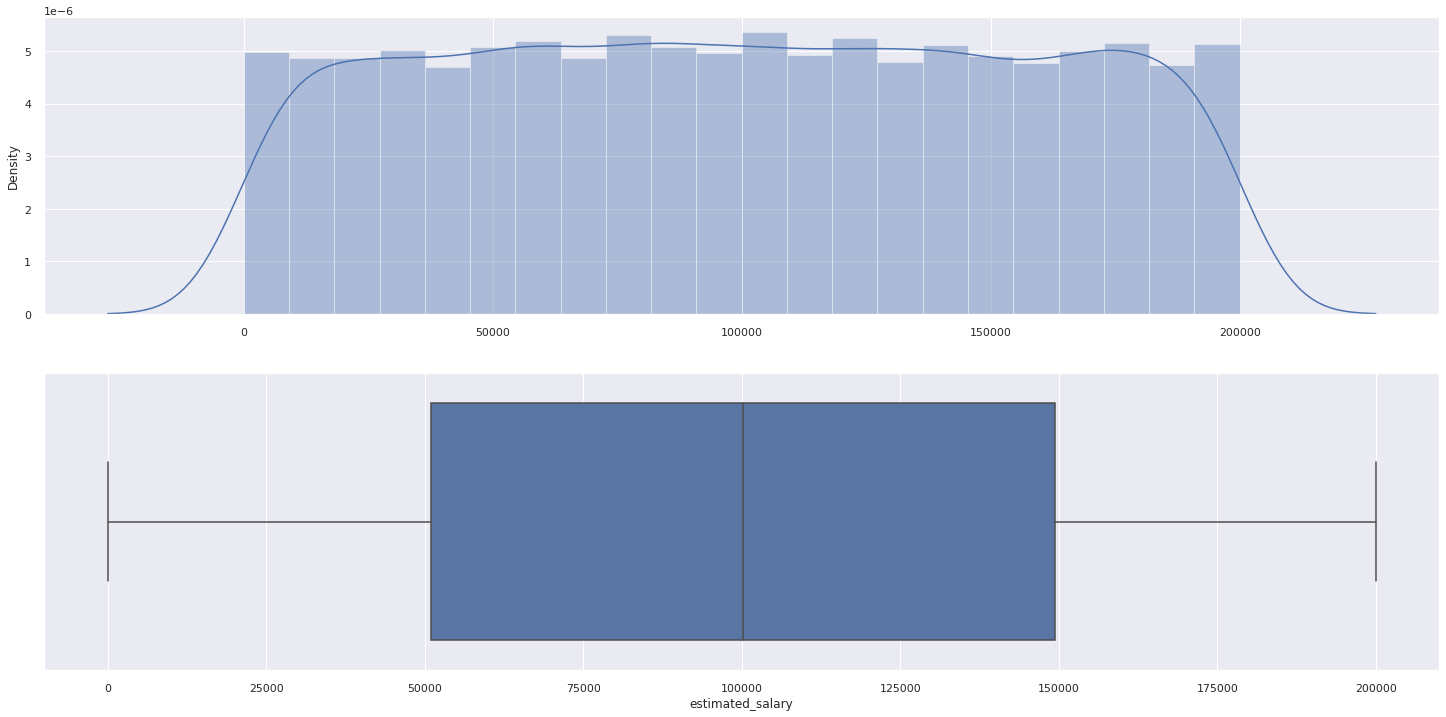

In [30]:

plt.subplot(2,1,1);
sns.distplot(x=df4['estimated_salary']);


plt.subplot(2,1,2);
sns.boxplot(x='estimated_salary', data=df4);

### 4.1.7 Exited

- It's unballanced, here can be a problem. The ML models can interpet class 0 (no churn) and learn more about this class than the main class 1(Churn) that represents the phenomenon we are trying to predict.

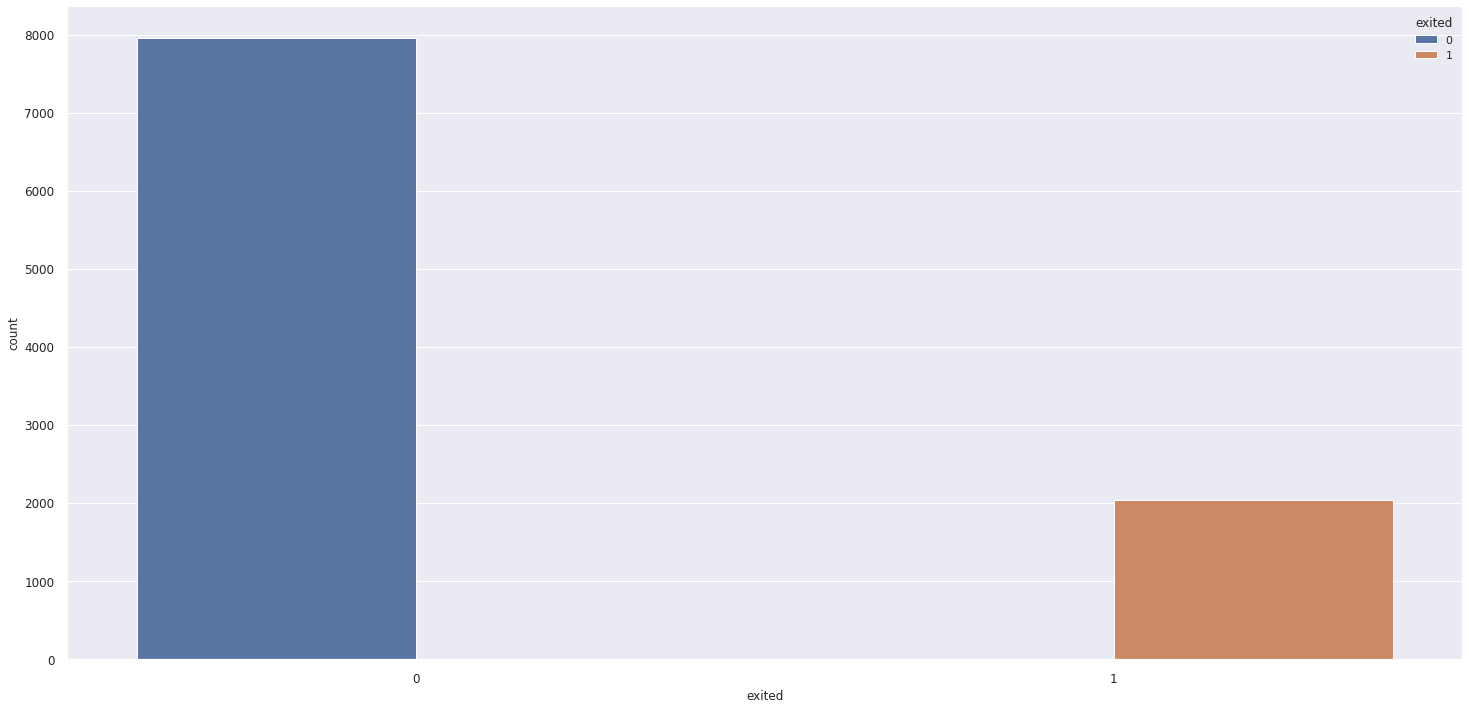

In [31]:
ax1 = sns.countplot(x='exited',hue='exited', data=df2);
plt.xticks(size=12);
plt.xlabel('exited', size=12);
plt.yticks(size=12);
plt.ylabel('count', size=12);

### 4.1.8 Numerical Attributes 

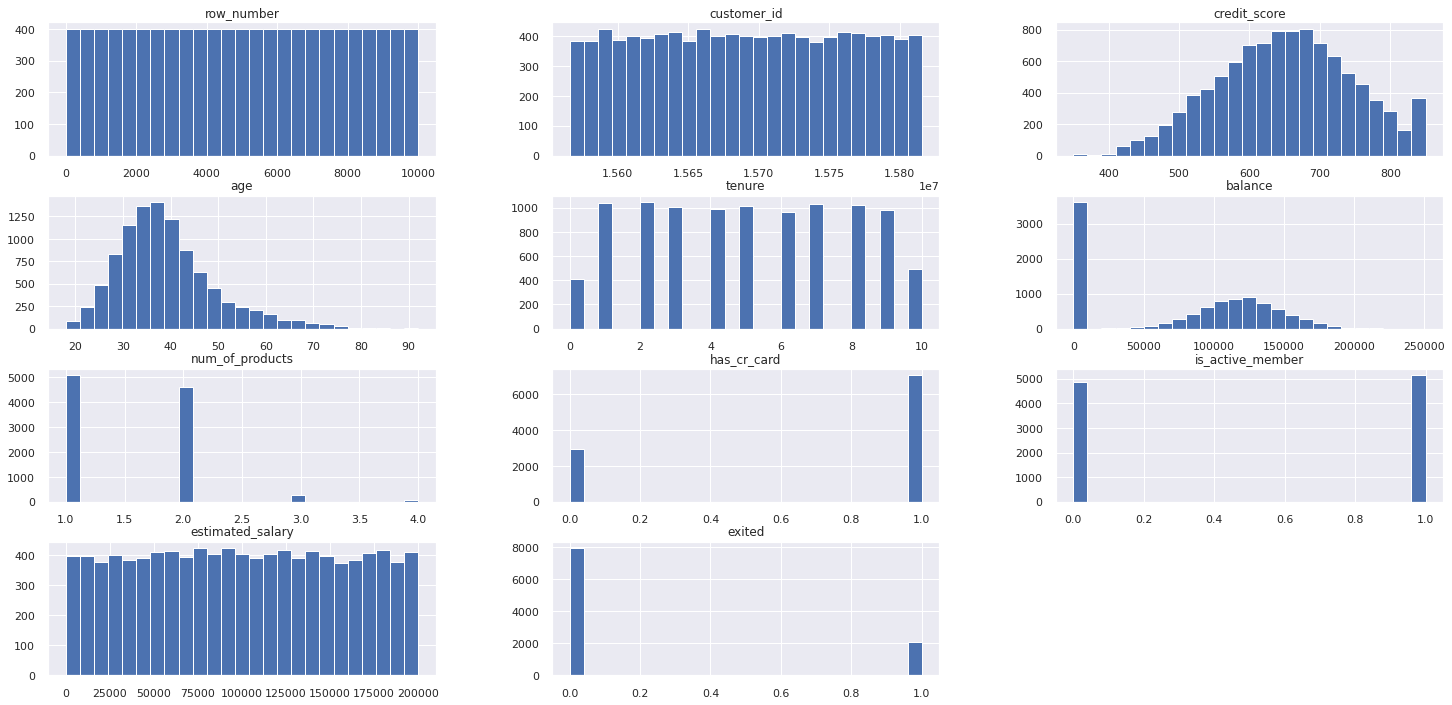

In [32]:
df1_num.hist(bins=25);

### 4.1.9 Categorical Attributes

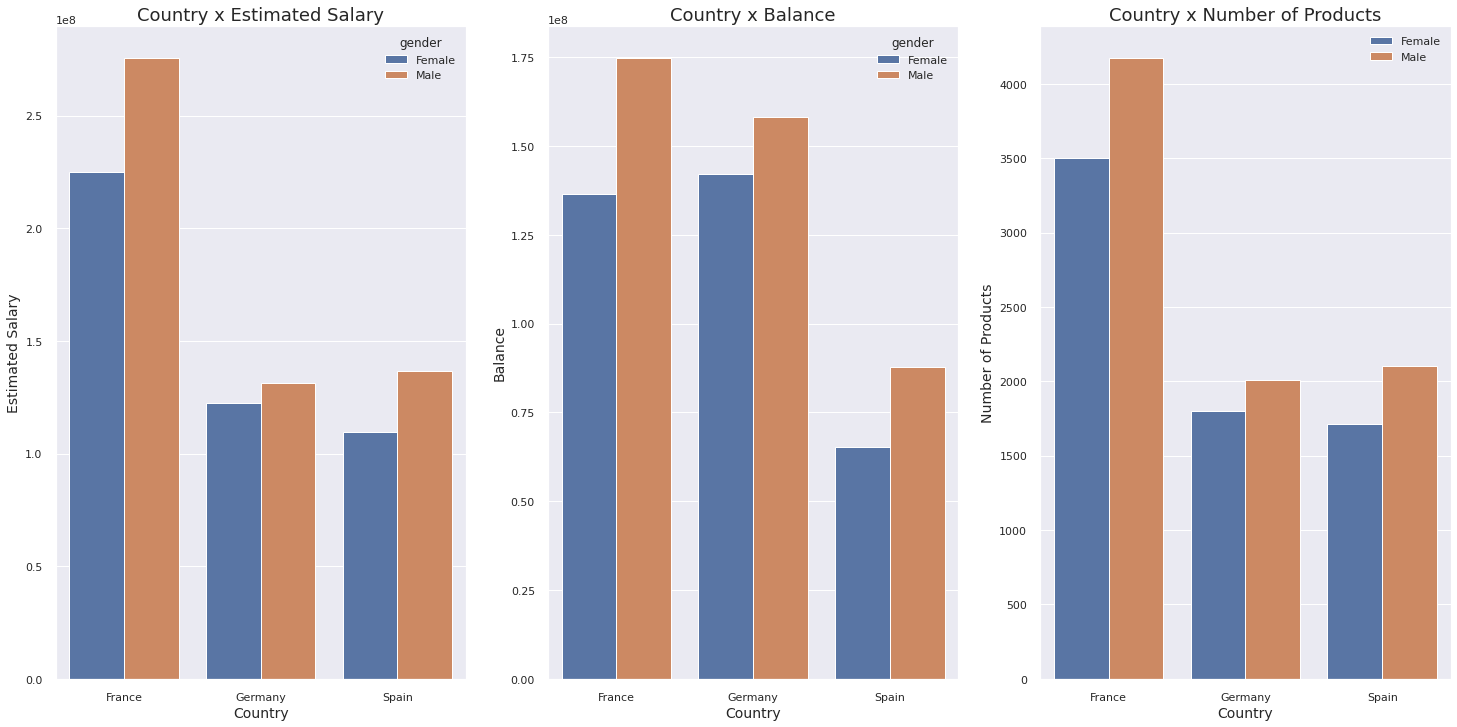

In [33]:
# check hue https://stackoverflow.com/questions/31749448/how-to-add-percentages-on-top-of-bars-in-seaborn

# Setting title and labels

def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

aux1 = df1[['geography', 'gender', 'balance']].groupby(['geography', 'gender']).sum().reset_index()

aux2 = df1[['geography', 'gender', 'estimated_salary']].groupby(['geography', 'gender']).sum().reset_index()

aux3 = df1[['geography', 'gender', 'num_of_products']].groupby(['geography', 'gender']).sum().reset_index()



# country 
fig, gr = plt.subplots()

plt.subplot(1,3,1)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'estimated_salary', data=aux2)
set_plots_features(gr, 'Country x Estimated Salary', 'Country', 'Estimated Salary')

plt.subplot(1,3,2)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'balance', data=aux1)
set_plots_features(gr, 'Country x Balance', 'Country', 'Balance')

plt.subplot(1,3,3)
gr = sns.barplot(x = 'geography', hue= 'gender', y = 'num_of_products', data=aux3)
set_plots_features(gr, 'Country x Number of Products', 'Country', 'Number of Products')

# Legend
plt.legend()

# Display the plot
plt.show()

## 4.2 Analise Bivariada

Now let's look at the correlation of the resources with the "closed" target variable. The main objective here is to better understand the data and business and especially which variables are most relevant to the machine start algorithm.

### H1. Os usuarios com score maior que 800 em media tem mais dinheiro no banco.
*Falso* os usuarios em media tem o mesmo valor 


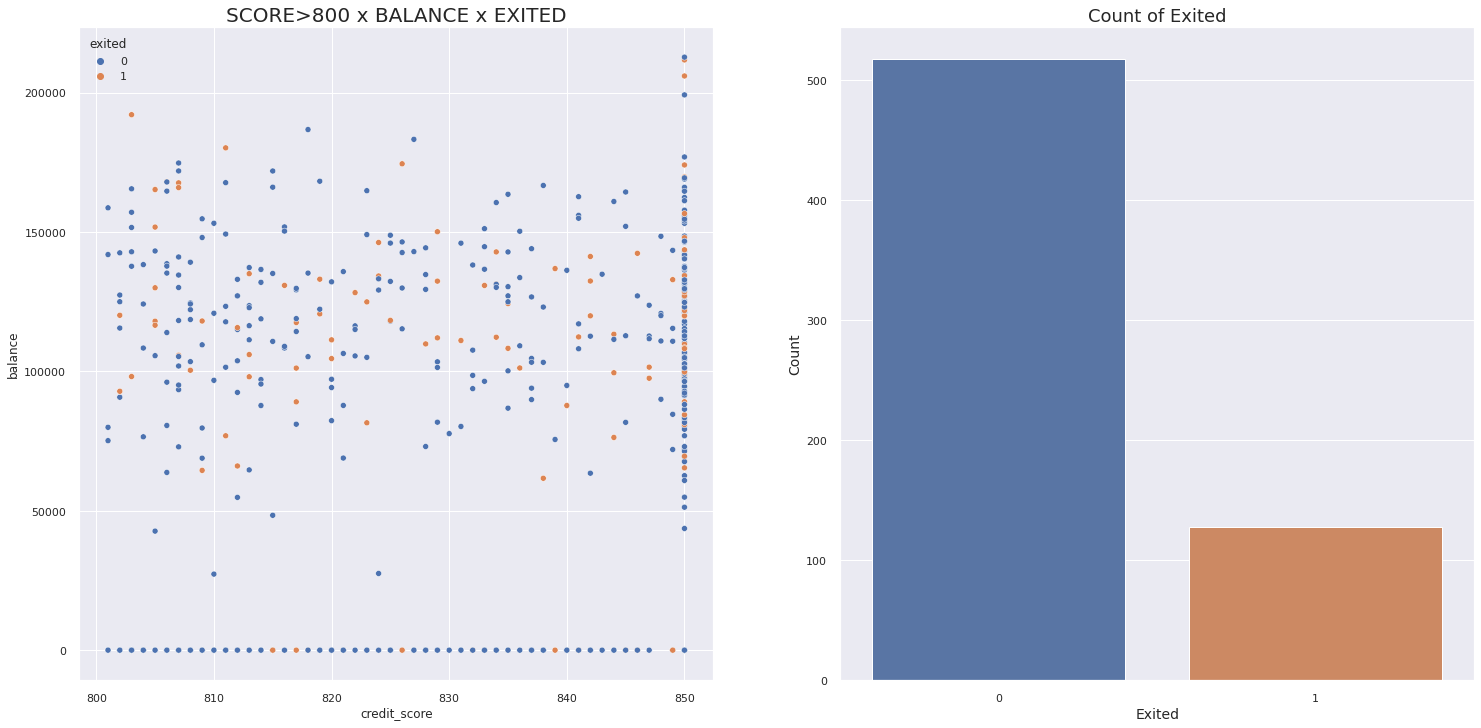

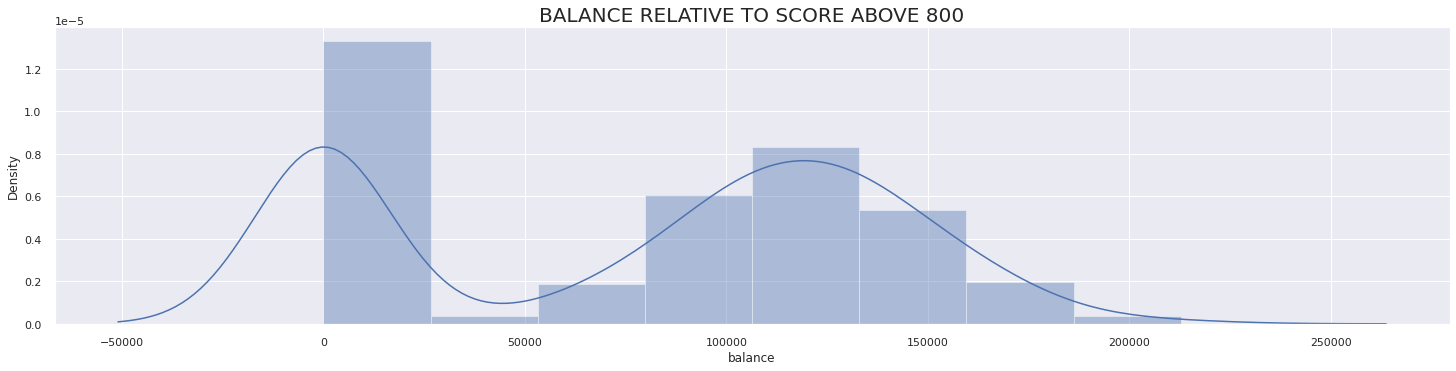

In [34]:
auxh1_h=df1[df1['credit_score']>800]
plt.subplot(1,2,1);
sns.scatterplot(x='credit_score',y='balance', hue='exited', data=auxh1_h).set_title('SCORE>800 x BALANCE x EXITED', fontsize=20);



# Count Plot
plt.subplot(1,2,2);

gr = sns.countplot(auxh1_h['exited']);
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count');


# Display the plot
plt.show();

plt.subplot(2,1,1)
auxdisth=df1.loc[df1['credit_score']>800, 'balance']
sns.distplot(auxdisth).set_title('BALANCE RELATIVE TO SCORE ABOVE 800', fontsize=20);

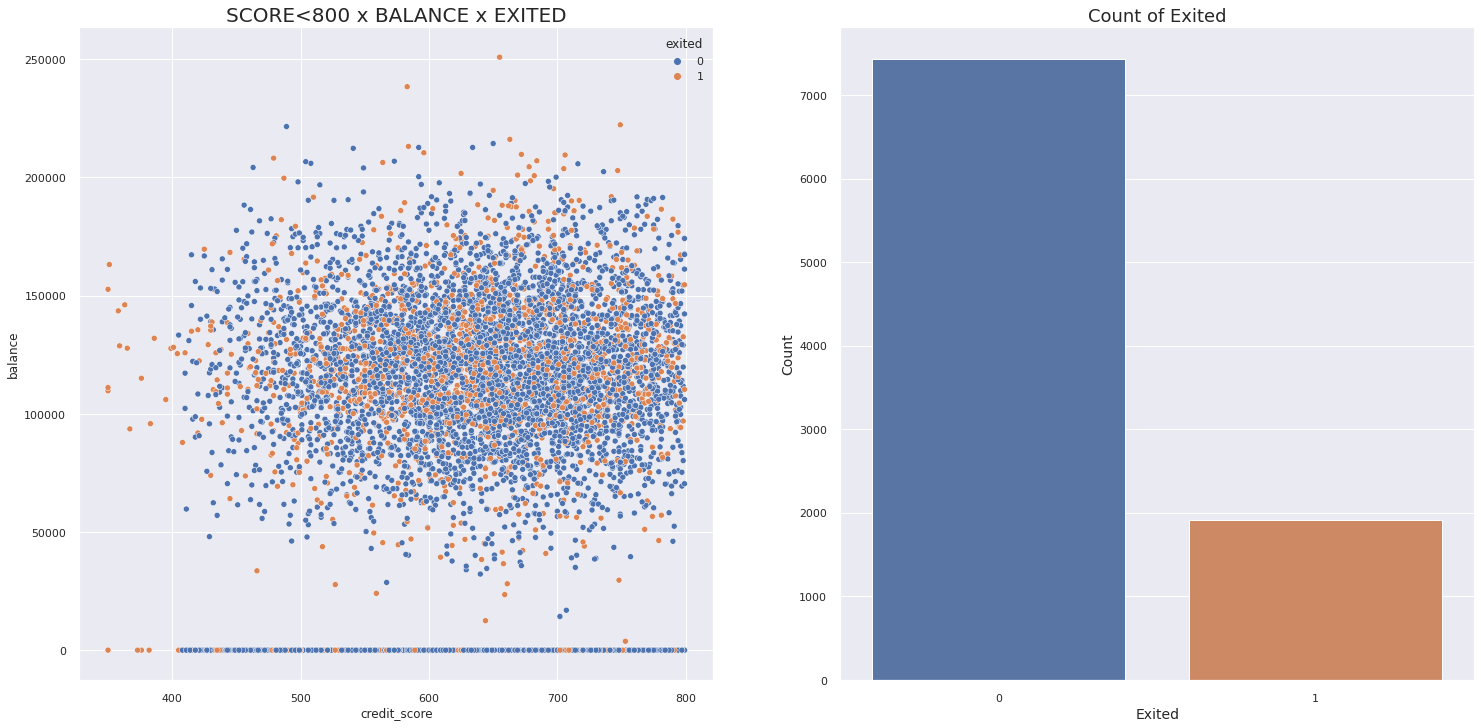

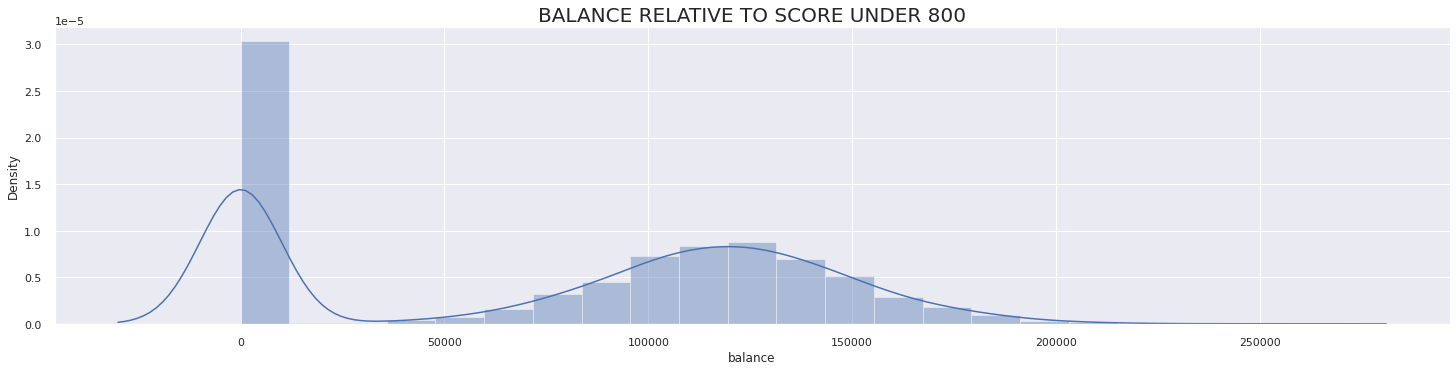

In [35]:
auxh1_l=df1[df1['credit_score']<800]
plt.subplot(1,2,1)
sns.scatterplot(x='credit_score',y='balance', hue='exited', data=auxh1_l).set_title('SCORE<800 x BALANCE x EXITED', fontsize=20);


# Count Plot
plt.subplot(1,2,2)

gr = sns.countplot(auxh1_l['exited'])
set_plots_features(gr, 'Count of Exited', 'Exited', 'Count')

# Display the plot
plt.show()

plt.subplot(2,1,1)
auxdistl=df1.loc[df1['credit_score']<800, 'balance']
sns.distplot(auxdistl).set_title('BALANCE RELATIVE TO SCORE UNDER 800', fontsize=20);

### H2. A espanha possui o maior numero de cartoes de credito da base de dados.
**Falso** a espanha possui o menor numero de cartoes com 2477


**observacao:** pessoas que possuem cartao de credito dao mais churn

<AxesSubplot:>

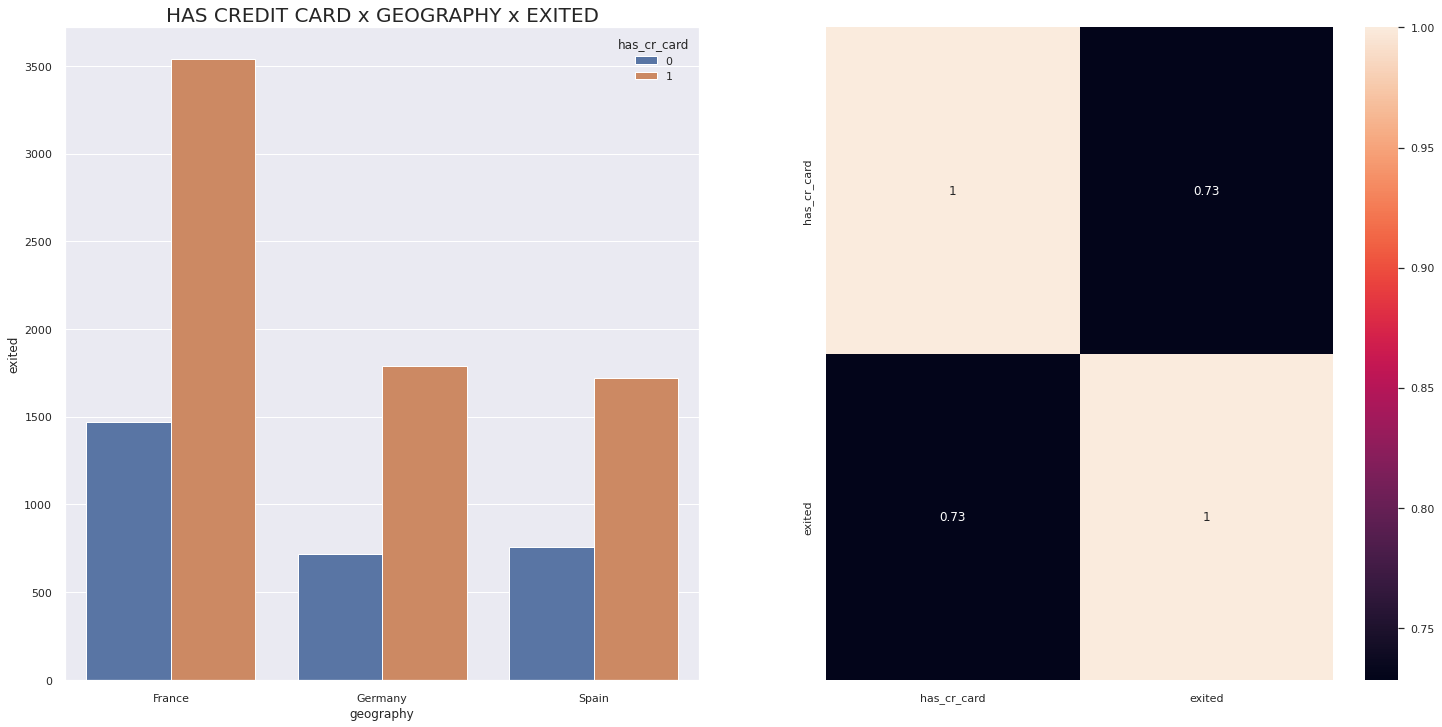

In [36]:
aux2=df4[['geography','has_cr_card','exited']].groupby(['geography','has_cr_card']).count().reset_index()
# aux2
plt.subplot(1,2,1)
sns.barplot(x='geography', y='exited', hue='has_cr_card', data=aux2).set_title('HAS CREDIT CARD x GEOGRAPHY x EXITED', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux2.corr( method='pearson' ), annot=True )

### H3. O publico feminino possui o score maior do que o masculino. 

**Falso** Homens e Mulheres em media tem o mesmo score.

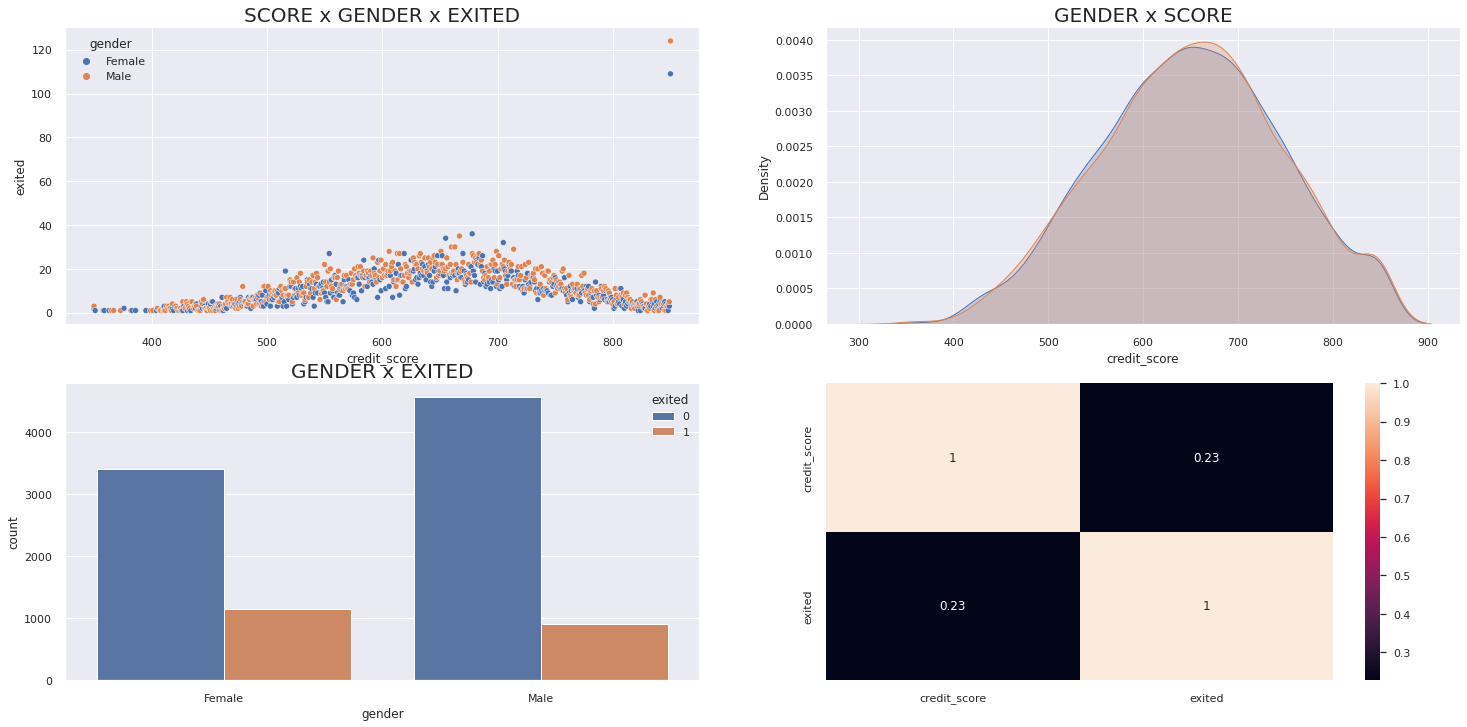

In [37]:
aux3=df4[['credit_score','gender','exited']].groupby(['credit_score','gender']).count().reset_index()

plt.subplot(2,2,1)
sns.scatterplot(hue='gender', x='credit_score', y='exited', data=aux3).set_title('SCORE x GENDER x EXITED', fontsize=20);
# plt.show()

plt.subplot(2,2,2)
sns.kdeplot( df4[df4['gender'] == 'Male']['credit_score'], label='MALE SCORE', shade=True ).set_title('GENDER x SCORE', fontsize=20);
sns.kdeplot( df4[df4['gender'] == 'Female']['credit_score'], label='FEMALE SCORE', shade=True );
# plt.show()

plt.subplot(2,2,3)
sns.countplot(x='gender', hue='exited', data=df4).set_title('GENDER x EXITED', fontsize=20);

plt.subplot(2,2,4)
sns.heatmap( aux3.corr( method='pearson' ), annot=True )
plt.show()





### H4. Homens possuem mais dinheiro do que mulheres no banco.

**Verdadeiro** Homens tem mais dinheiro no bando que mulheres e dao menos churn tambem.

<AxesSubplot:>

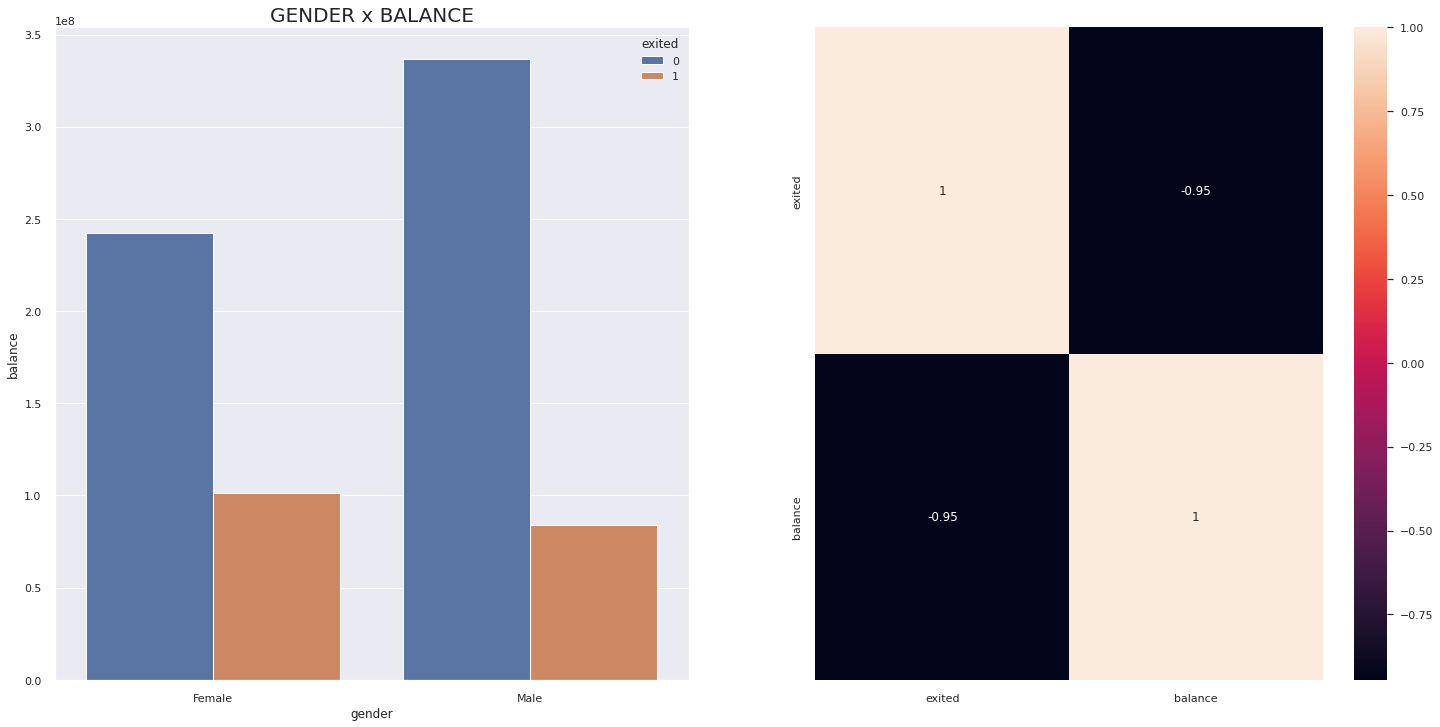

In [38]:
aux4=df4[['gender', 'exited', 'balance']].groupby(['gender', 'exited']).sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='gender', y='balance', hue='exited', data=aux4).set_title('GENDER x BALANCE', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux4.corr( method='pearson' ), annot=True )


###  H5. O salario estimados das mulherem em media eh maior do que dos homens.

**Falso** a distribuicao eh proxima de uma unitaria.

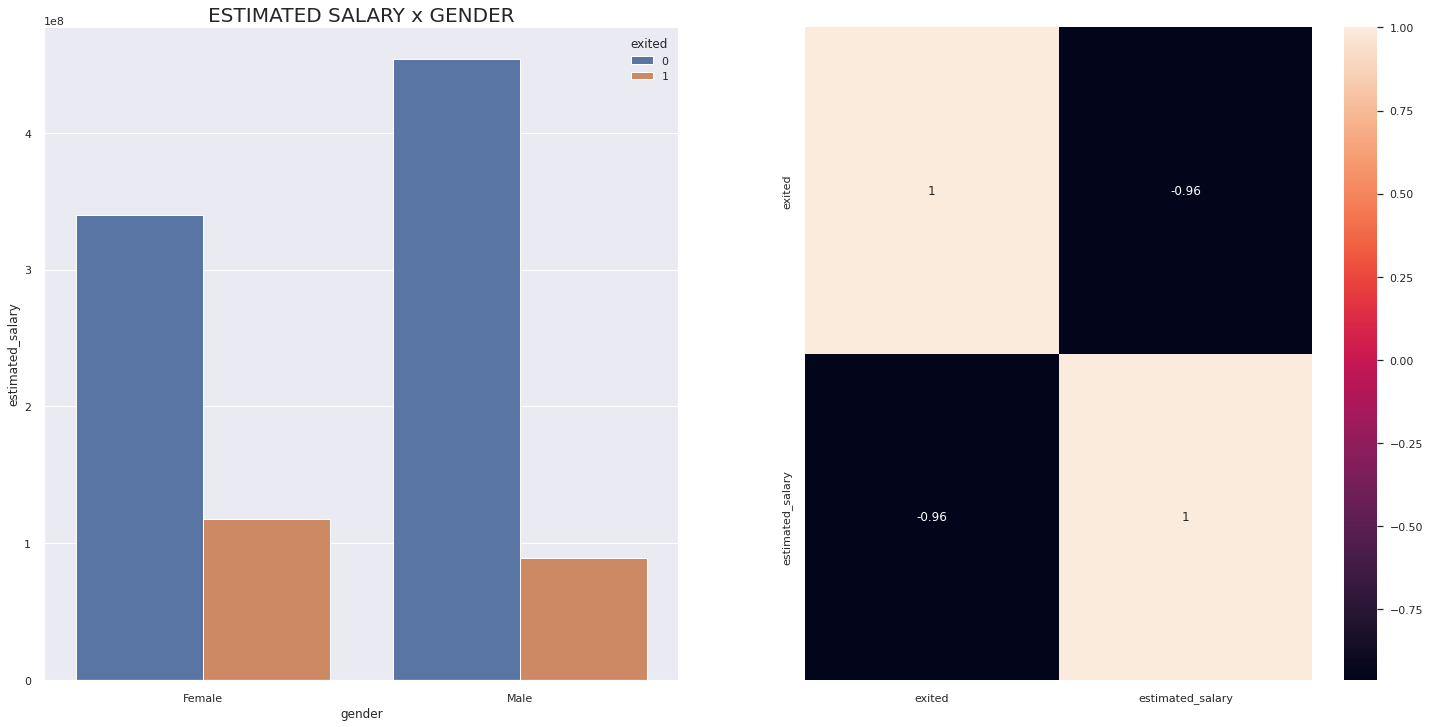

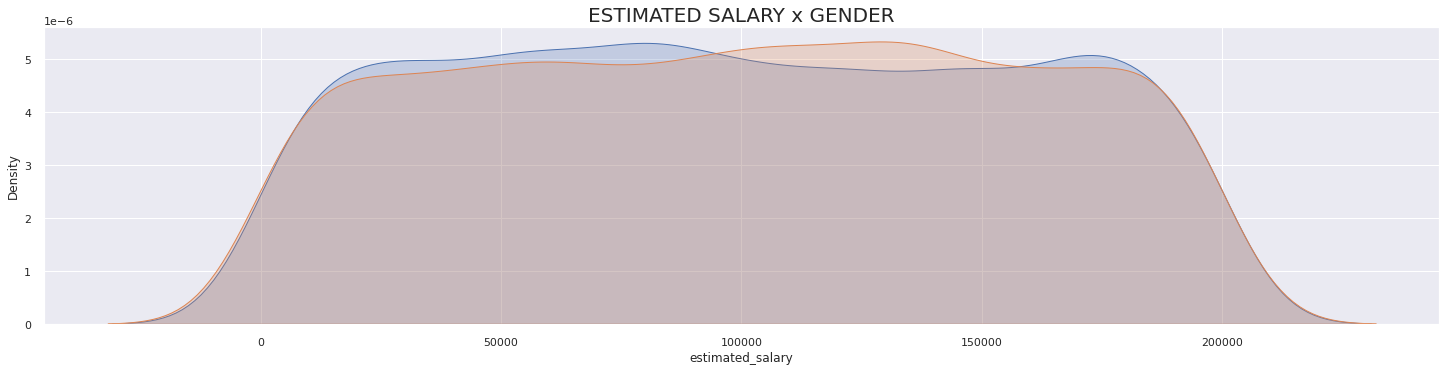

In [39]:
aux5=df4[['gender', 'exited', 'estimated_salary']].groupby(['gender', 'exited']).sum().reset_index()
# aux5
plt.subplot(1,2,1)
sns.barplot(x='gender', y='estimated_salary', hue='exited', data=aux5).set_title('ESTIMATED SALARY x GENDER', fontsize=20);

plt.subplot(1,2,2)
sns.heatmap( aux5.corr( method='pearson' ), annot=True )
plt.show()


plt.subplot(2,1,1 )
sns.kdeplot( df4[df4['gender'] == 'Male']['estimated_salary'], label='MALE ESTIMATED SALARY', shade=True ).set_title('ESTIMATED SALARY x GENDER', fontsize=20);
sns.kdeplot( df4[df4['gender'] == 'Female']['estimated_salary'], label='FEMALE ESTIMATED SALARY', shade=True );





### H6. Pessoas que moram na alemanha em media sao mais ativos que os demais.

**False** a Franca que possue o maior numero de usuarios ativos.


**obs**: devido aos dados estarem desbalanceados a franca leva a maioria neste experimento.

  geography  is_active_member  exited
0    France                 0    2423
1    France                 1    2591
2   Germany                 0    1261
3   Germany                 1    1248
4     Spain                 0    1165
5     Spain                 1    1312


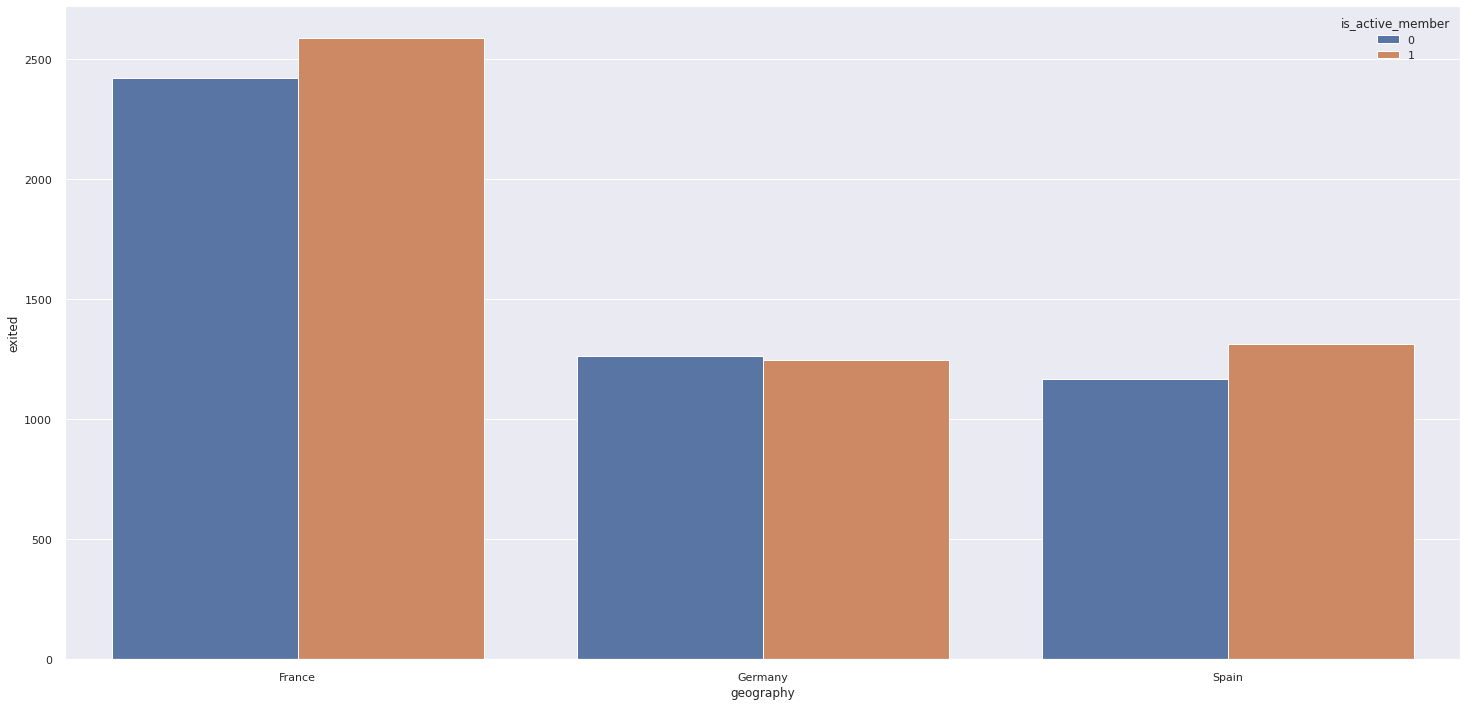

In [40]:
aux6=df4[['geography', 'exited', 'is_active_member']].groupby(['geography','is_active_member']).count().reset_index()
print(aux6)
sns.barplot(x='geography', hue='is_active_member', y='exited', data=aux6);

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes before


**Numerical attributes** indicates that **age, balance and num_of_products** has some correlation with our target variable, but nothing strong.

In order to improve the machine learning algorithm we should create some new features based on this three features.

It should be:

- balance_by_age = balance / age

- balance_by_num_of_products = balance / num_of_products

- num_of_products_by_age = num_of_products / age

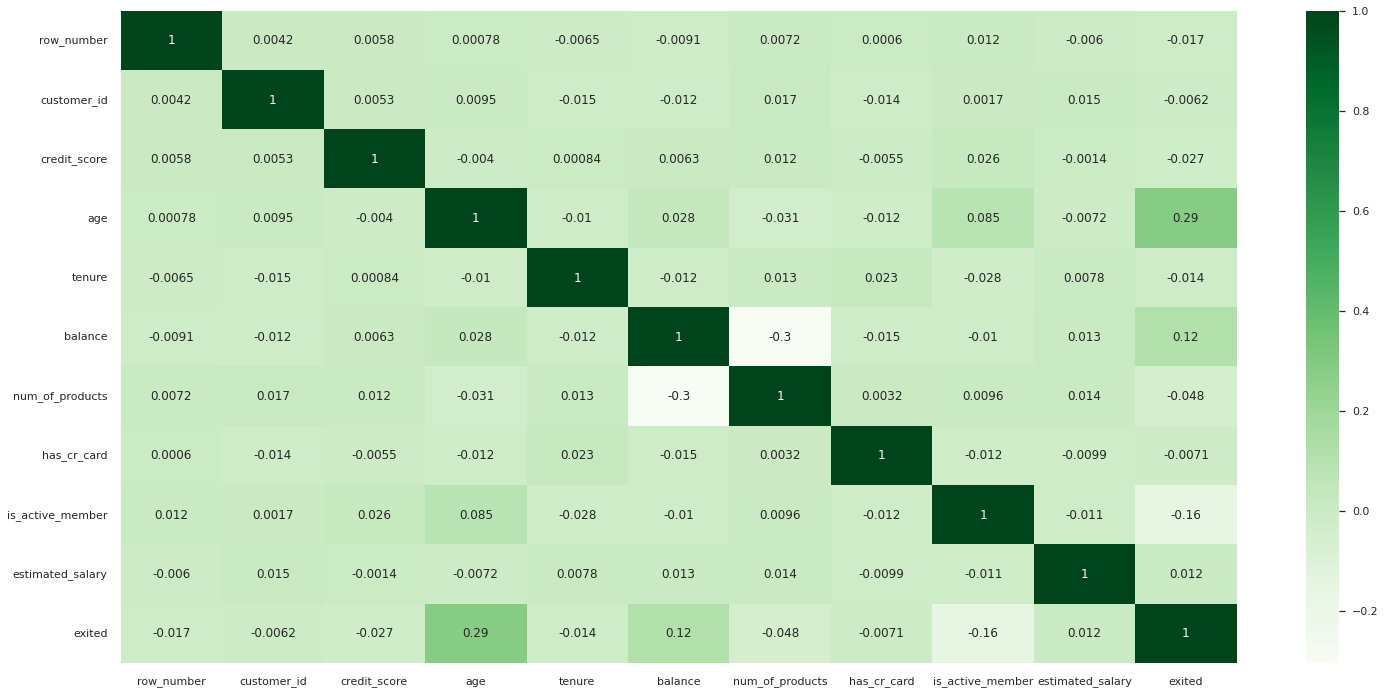

In [41]:
correlation=df1_num.corr(method='pearson')
sns.heatmap(correlation, cmap='Greens',annot=True);


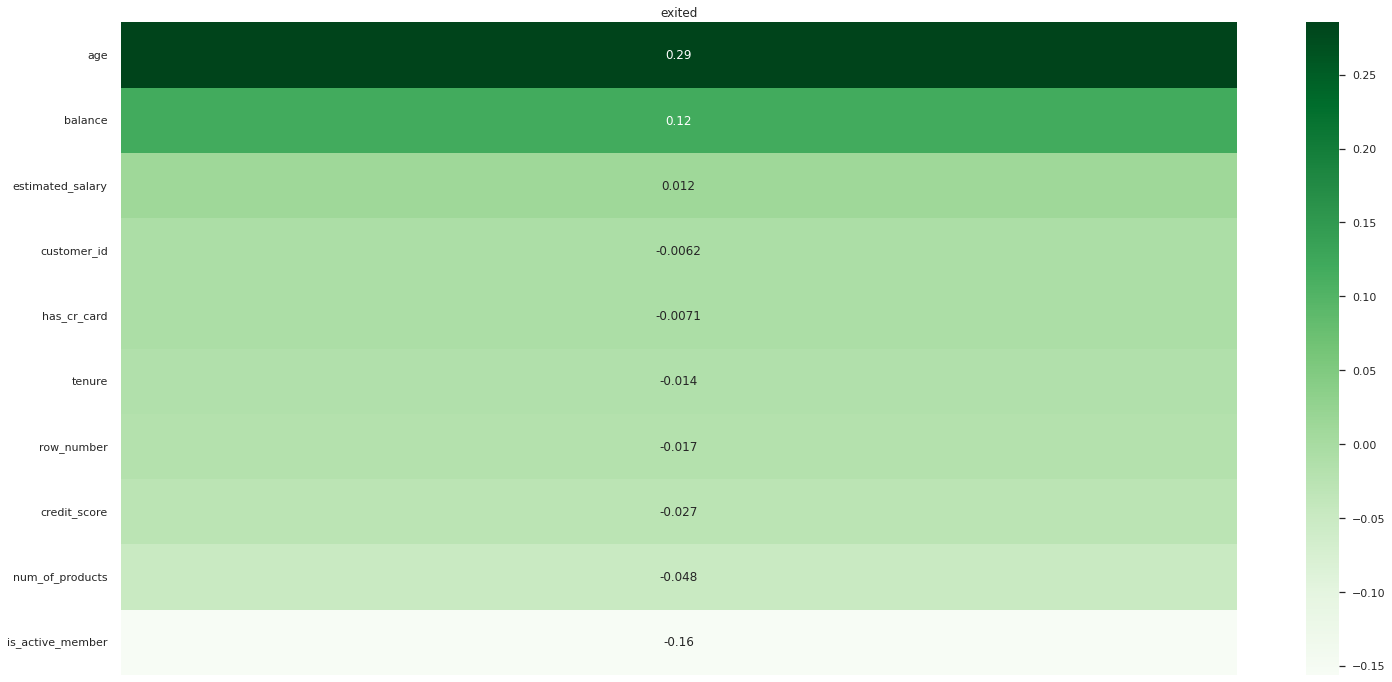

In [42]:
 #See the result in correlation to the target variable 

plot_corr('exited') ;

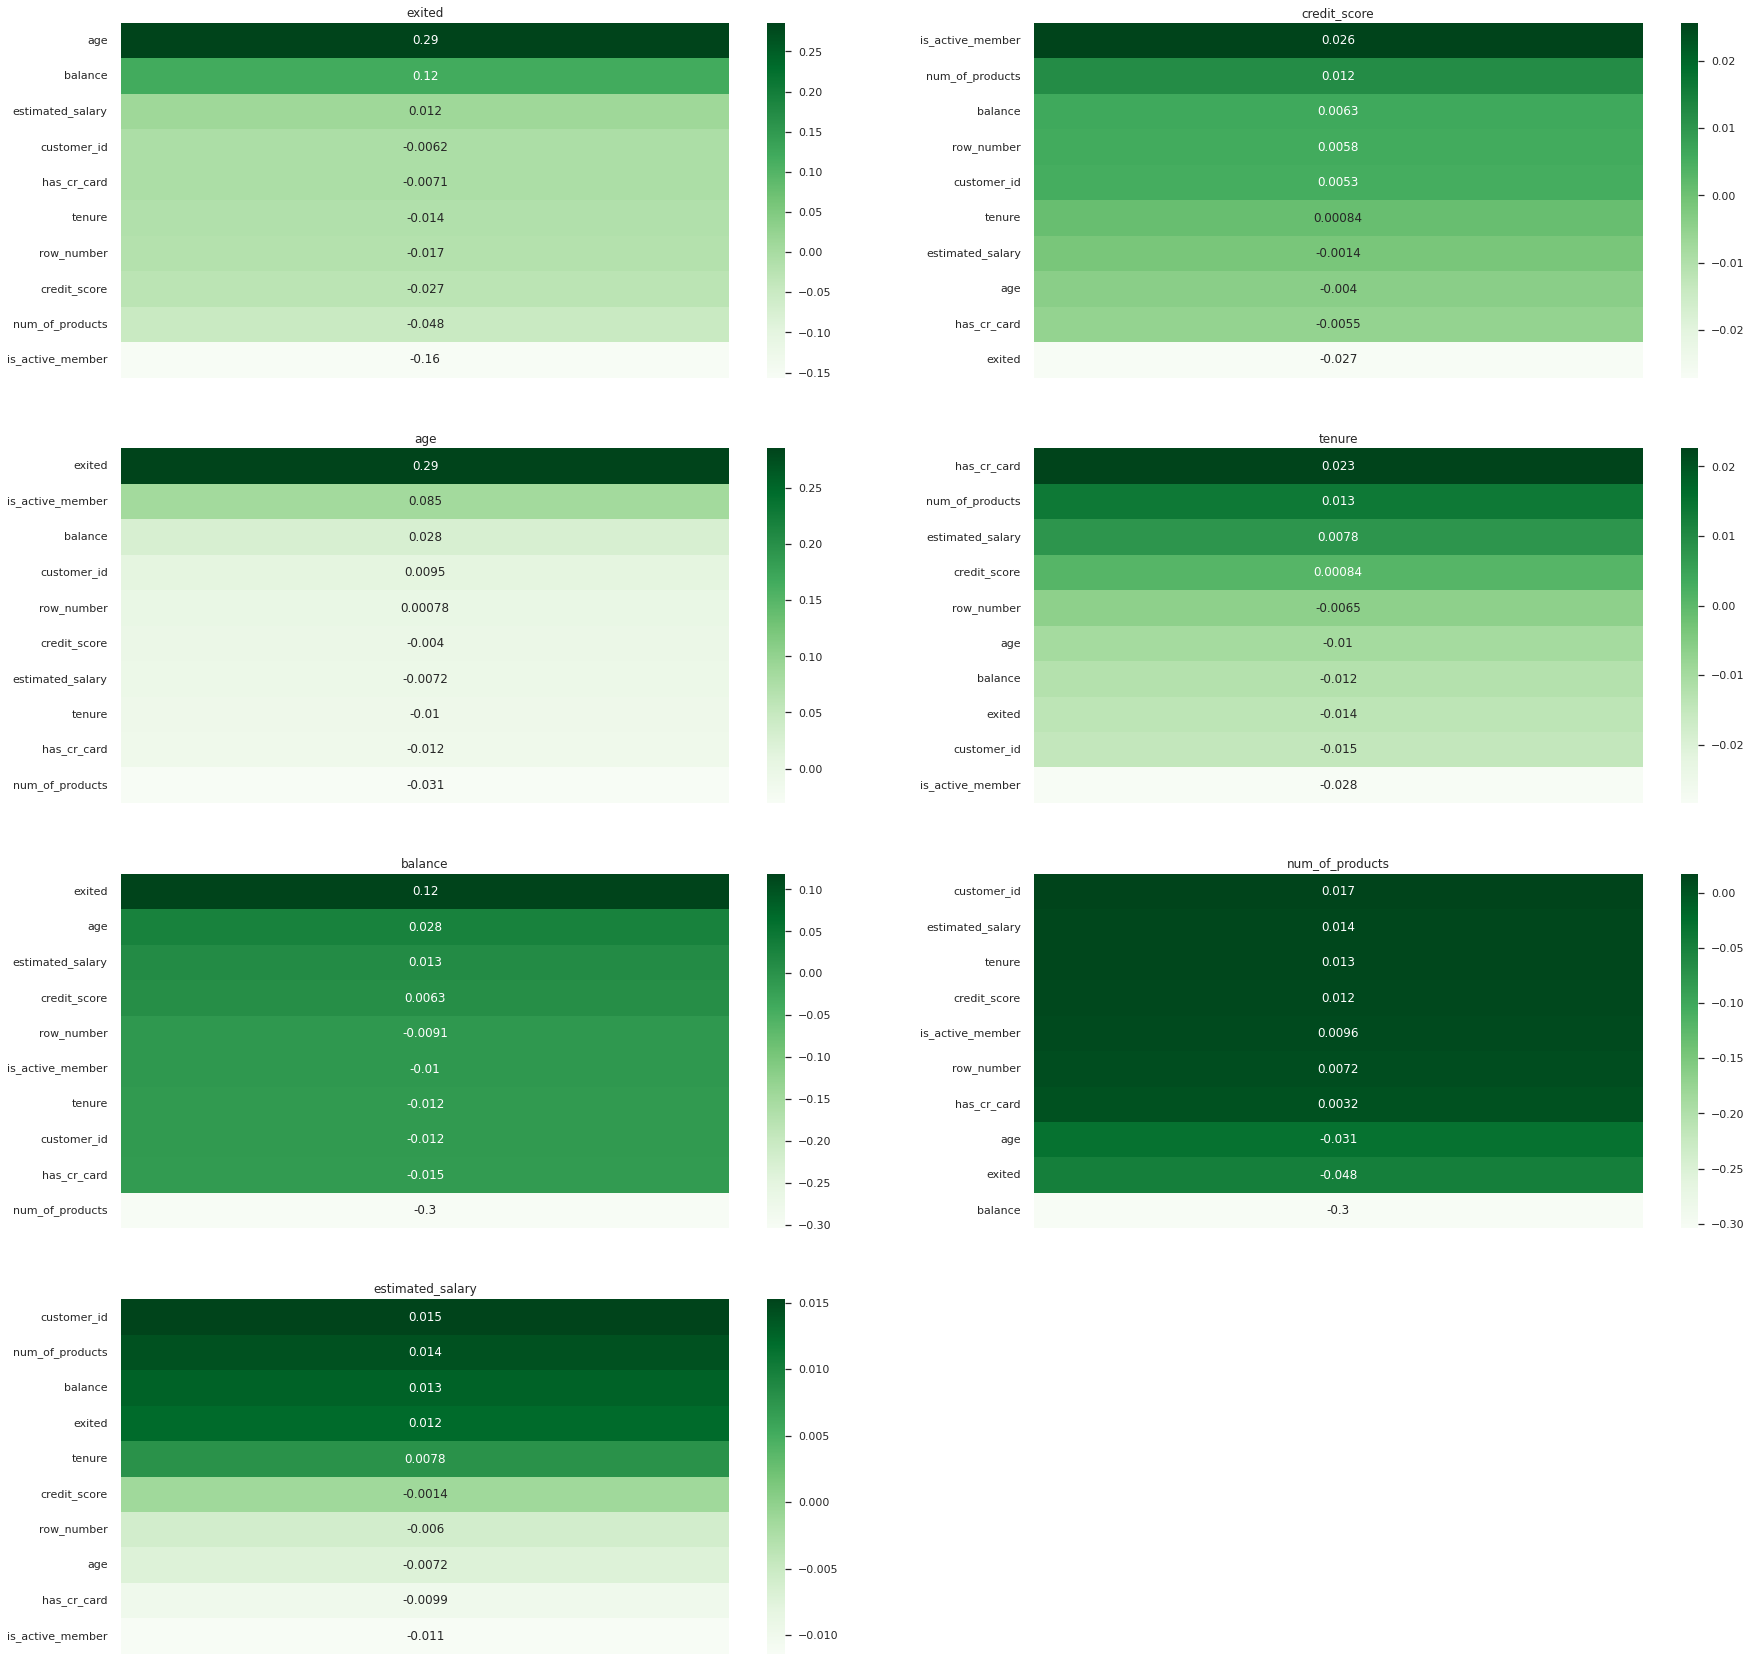

In [43]:
# Ranking of correlation between each variable 

plt.subplots(figsize=(30,30))
plt.subplot(4,2,1)
plot_corr('exited')

plt.subplot(4,2,2)
plot_corr('credit_score') 

plt.subplot(4,2,3)
plot_corr('age') 

plt.subplot(4,2,4)
plot_corr('tenure') 

plt.subplot(4,2,5)
plot_corr('balance') 

plt.subplot(4,2,6)
plot_corr('num_of_products') 

plt.subplot(4,2,7)
plot_corr('estimated_salary') ;

#### 4.3.1.1 Numerical Attributes after

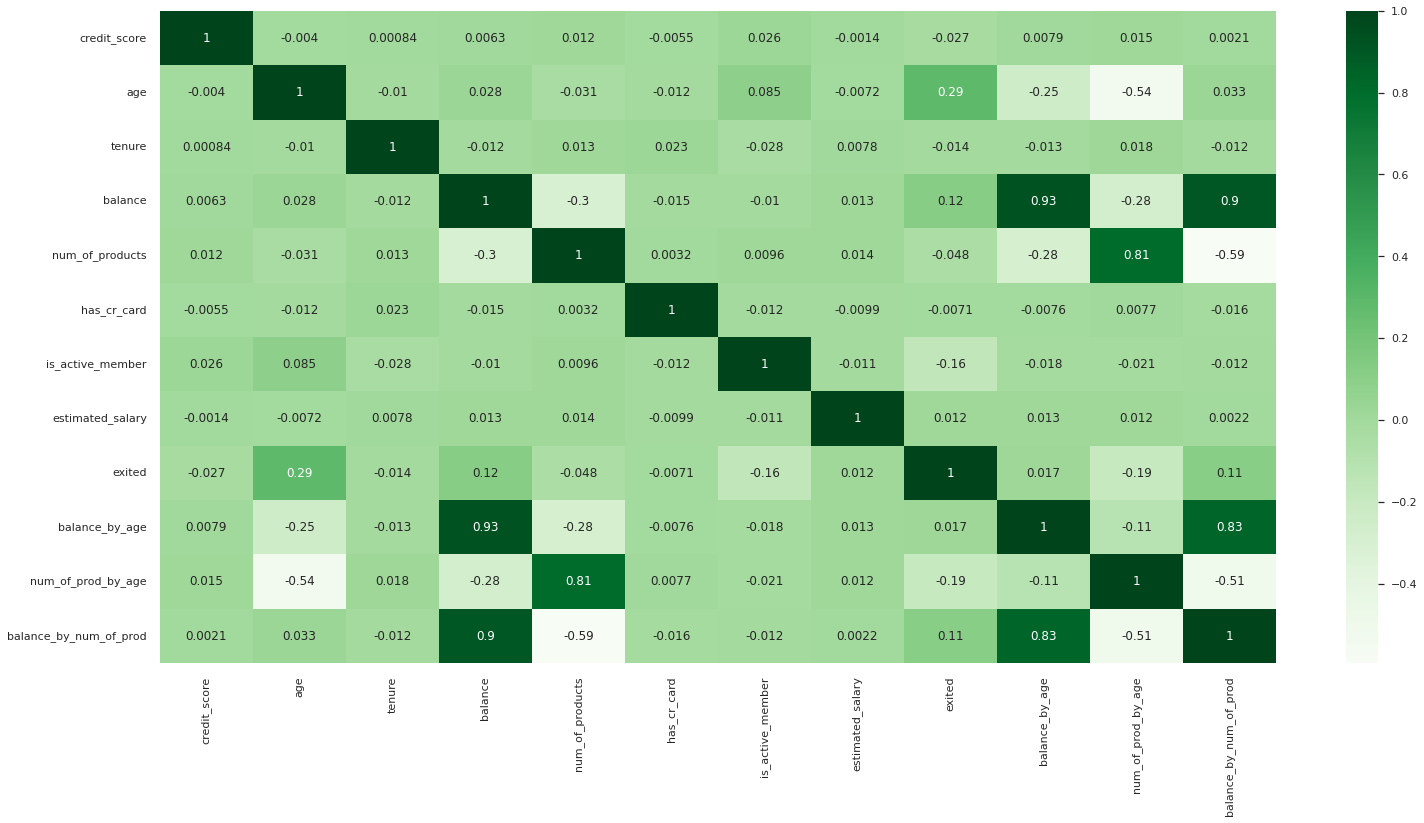

In [44]:
df4_nw_feat=df4.select_dtypes(include=['int64','float64'])

correlation=df4_nw_feat.corr(method='pearson')
sns.heatmap(correlation, cmap='Greens',annot=True);

### 4.3.2 Categorical Attributes

In order to analyse the correlation between categorical attributes I applied Cramer's V method (https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

Churn correlation happens between gender, geo and is active member, it's not too strong but considerable.

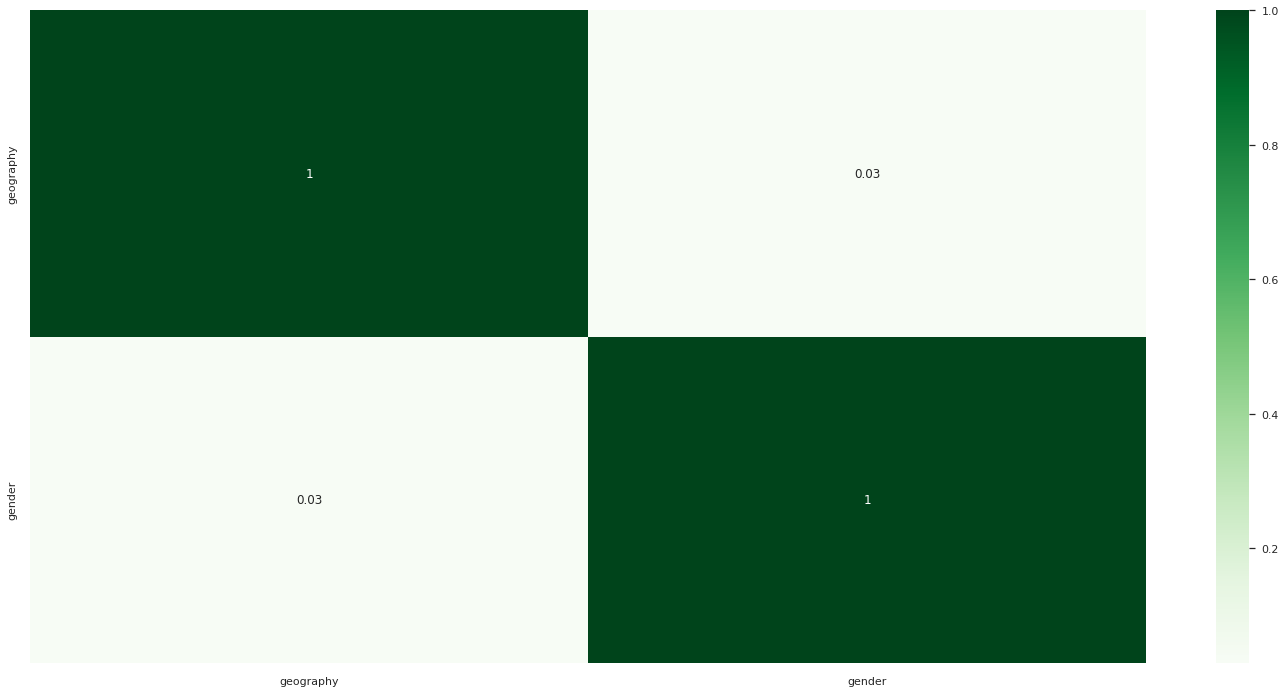

In [45]:
a = df4.select_dtypes(exclude=['float64','int64'])
rows= []

for var1 in a:
  col = []
  for var2 in a :
    
    # Cramer's V test
    cramers =cramer_v(a[var1], a[var2]) 
    # Keeping of the rounded value of the Cramer's V  
    col.append(round(cramers,2)) 
    
  rows.append(col)
  
cramers_results = np.array(rows)
dfcv = pd.DataFrame(cramers_results, columns = a.columns, index =a.columns)
sns.heatmap(dfcv, cmap='Greens', annot=True);

# 5.0 PREPARACAO DE DADOS


In [46]:
df5=df4.copy()

In [47]:
# X = df4.drop( 'exited', axis=1 )
# y = df4['exited'].copy() 

# x_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20 )

# df5 = pd.concat( [x_train, y_train], axis=1 )
# df5.shape

### Graphs

credit_score

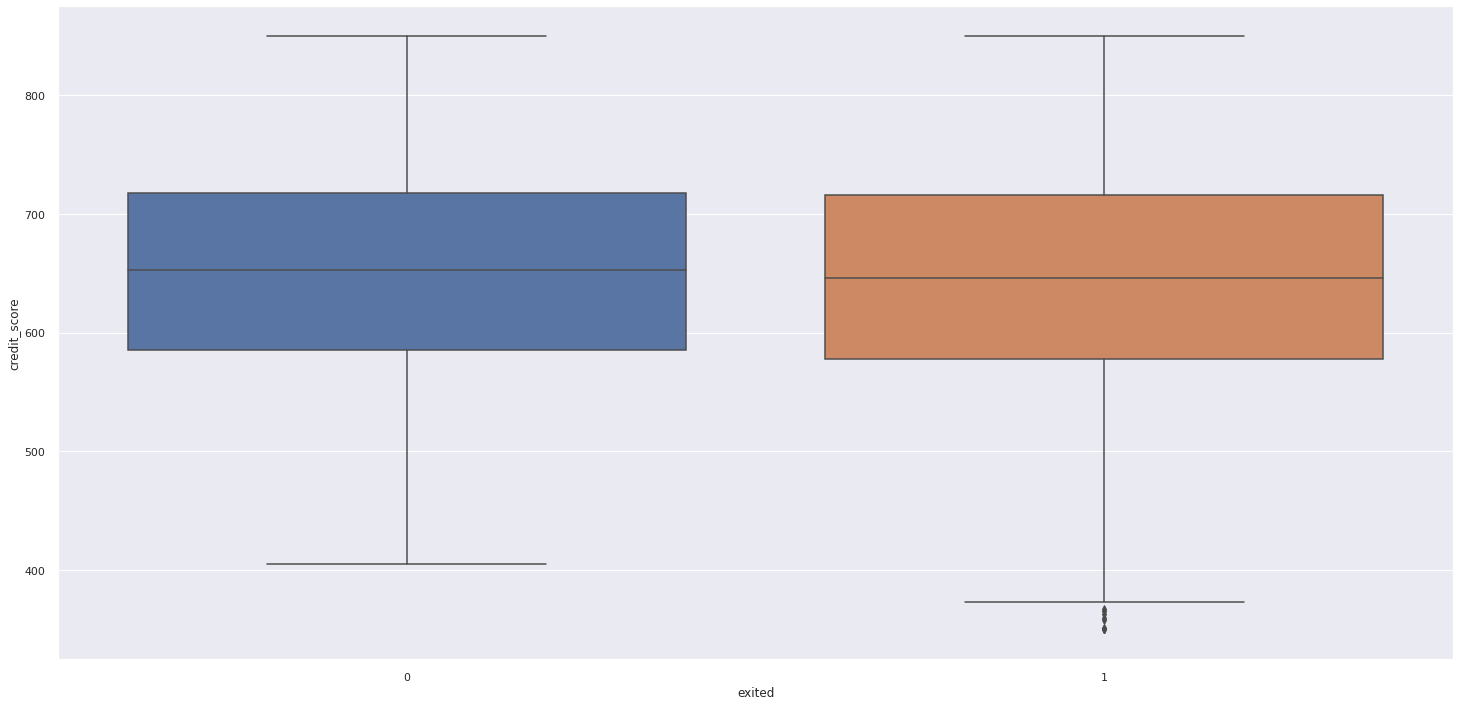

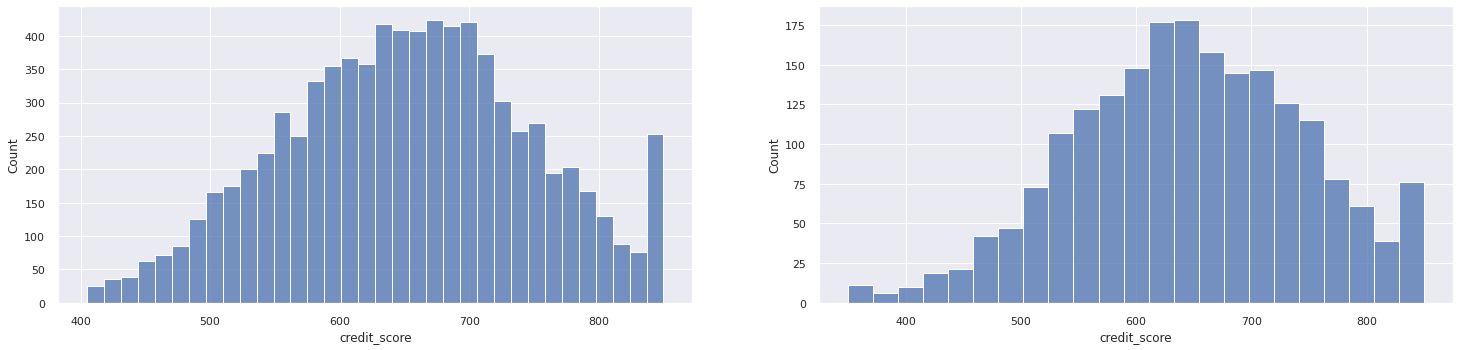

In [48]:
plt.subplot(1,1,1)
sns.boxplot(x='exited', y='credit_score', data=df5);
plt.show()

plt.subplot(2,2,1)
aux1=df5.loc[df5['exited']== 0, 'credit_score']
sns.histplot(aux1);

plt.subplot(2,2,2)
aux1=df5.loc[df5['exited']== 1, 'credit_score']
sns.histplot(aux1);

age

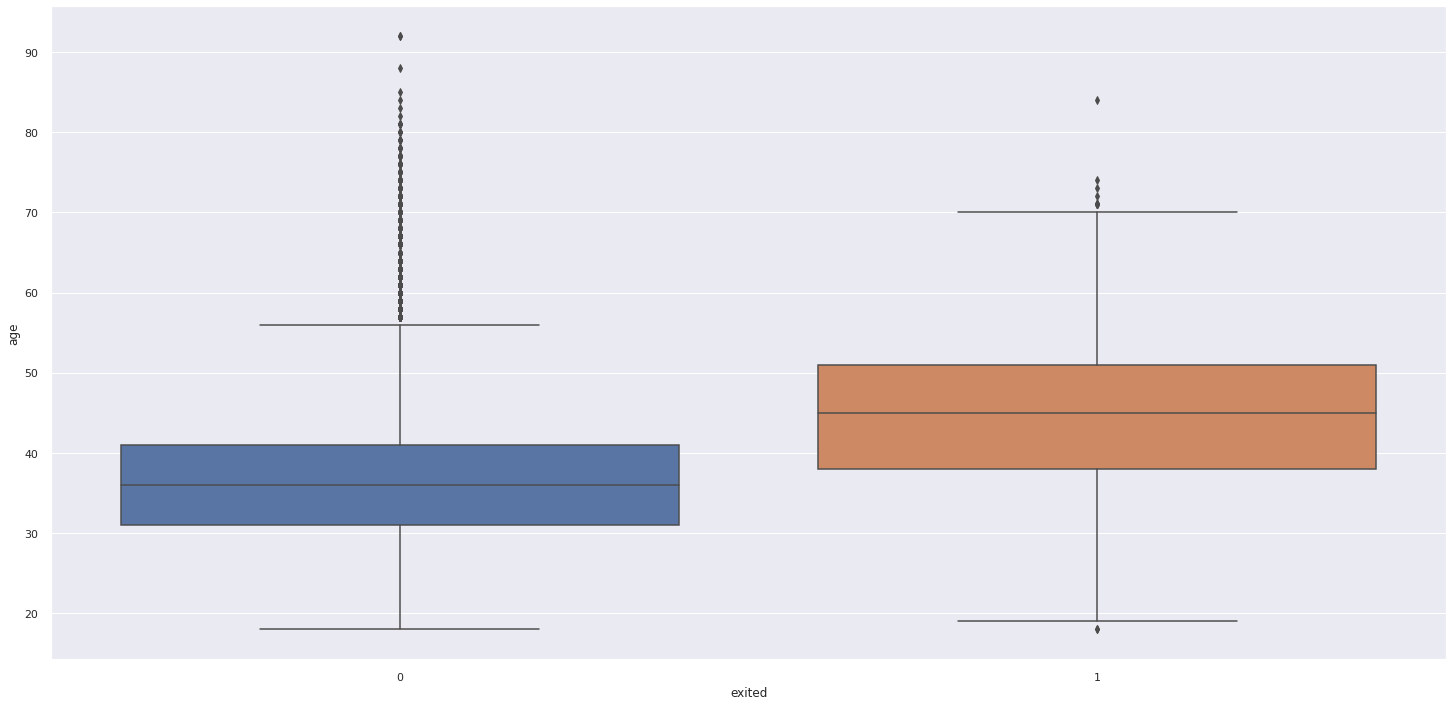

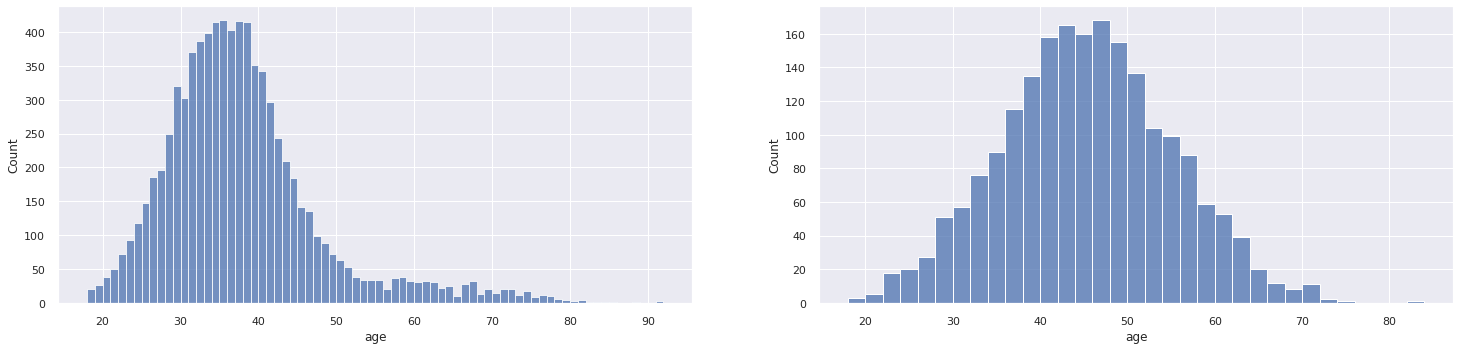

In [49]:
plt.subplot(1,1,1)
sns.boxplot(x='exited', y='age', data=df5);
plt.show()

plt.subplot(2,2,1)
aux1=df5.loc[df5['exited']== 0, 'age']
sns.histplot(aux1);

plt.subplot(2,2,2)
aux1=df5.loc[df5['exited']== 1, 'age']
sns.histplot(aux1);

In [50]:
# aux=df5.drop(['customer_id', 'geography', 'gender', 'exited'],axis=1)
# aux.head()

tenure

In [51]:
# plt.subplot(1,1,1)
# sns.boxplot(x='exited', y='tenure', data=df5);
# plt.show()

# plt.subplot(2,2,1)
# aux1=df5.loc[df5['exited']== 0, 'tenure']
# sns.histplot(aux1);

# plt.subplot(2,2,2)
# aux1=df5.loc[df5['exited']== 1, 'tenure']
# sns.histplot(aux1);

balance

In [52]:
# plt.subplot(1,1,1)
# sns.boxplot(x='exited', y='balance', data=df5);
# plt.show()

# plt.subplot(2,2,1)
# aux1=df5.loc[df5['exited']== 0, 'balance']
# sns.histplot(aux1);

# plt.subplot(2,2,2)
# aux1=df5.loc[df5['exited']== 1, 'balance']
# sns.histplot(aux1);

num_of_products

In [53]:
# plt.subplot(1,1,1)
# sns.boxplot(x='exited', y='num_of_products', data=df5);
# plt.show()

# plt.subplot(2,2,1)
# aux1=df5.loc[df5['exited']== 0, 'num_of_products']
# sns.histplot(aux1);

# plt.subplot(2,2,2)
# aux1=df5.loc[df5['exited']== 1, 'num_of_products']
# sns.histplot(aux1);

has_cr_card

In [54]:
# plt.subplot(1,1,1)
# sns.boxplot(x='exited', y='has_cr_card', data=df5);
# plt.show()

# plt.subplot(2,2,1)
# aux1=df5.loc[df5['exited']== 0, 'has_cr_card']
# sns.histplot(aux1);

# plt.subplot(2,2,2)
# aux1=df5.loc[df5['exited']== 1, 'has_cr_card']
# sns.histplot(aux1);

is_active_member

estimated_salary

In [55]:
# plt.subplot(1,1,1)
# sns.boxplot(x='exited', y='estimated_salary', data=df5);
# plt.show()

# plt.subplot(2,2,1)
# aux1=df5.loc[df5['exited']== 0, 'estimated_salary']
# sns.histplot(aux1);

# plt.subplot(2,2,2)
# aux1=df5.loc[df5['exited']== 1, 'estimated_salary']
# sns.histplot(aux1);

## 5.1 Standardization

In [56]:
# sns.boxplot(df5['credit_score']);

In [57]:
# sns.histplot(df5['credit_score']);

credit_score

In [58]:
# scaler = StandardScaler()
# df5['credit_score'] = scaler.fit_transform(df5[['credit_score']].values)
# pickle.dump(scaler, open('/home/tc0019/DS/topbottom/parameter/credit_score.pkl', 'wb' ))



In [59]:
ba=df5.columns.to_list()
print(ba)

['credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited', 'balance_by_age', 'num_of_prod_by_age', 'balance_by_num_of_prod']


##  5.2 Rescaling


age robust scaler - possui outliers

estimated_salary

In [60]:
rs=RobustScaler()
mms=MinMaxScaler()

# age - robust scaler devido a outliers
df5['age']=mms.fit_transform(df5[['age']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/age_scaler.pkl', 'wb' ))

df5['credit_score'] = rs.fit_transform(df5[['credit_score']].values)
pickle.dump(rs, open('/home/tc0019/DS/topbottom/parameter/credit_score.pkl', 'wb' ))

# estimated salary
df5['estimated_salary']=mms.fit_transform(df5[['estimated_salary']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/estimated_salary_scaler.pkl', 'wb' ))

# tenure
df5['tenure'] = mms.fit_transform(df5[['tenure']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/tenure_scaler.pk1', 'wb'))

# balance
df5['balance'] = mms.fit_transform(df5[['balance']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/balance_scaler.pk1', 'wb'))

# num_of_products
df5['num_of_products'] = mms.fit_transform(df5[['num_of_products']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/num_of_products_scaler.pk1', 'wb'))

# balance_by_age
df5['balance_by_age'] = mms.fit_transform(df5[['balance_by_age']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/balance_by_age_scaler.pk1', 'wb'))

# balance_by_num_of_prod
df5['balance_by_num_of_prod'] = mms.fit_transform(df5[['balance_by_num_of_prod']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/balance_by_num_of_prod_scaler.pk1', 'wb'))

# num_of_prod_by_age
df5['num_of_prod_by_age'] = mms.fit_transform(df5[['num_of_prod_by_age']].values)
pickle.dump(mms, open('/home/tc0019/DS/topbottom/parameter/num_of_prod_by_age_scaler.pk1', 'wb'))



## 5.3 Transformation


### 5.3.1 Encoding

In [61]:

# col = ColumnTransformer([('encoder', OneHotEncoder(), ['gender', 'has_cr_card', 'is_active_member'])], remainder='passthrough')
# pipe=Pipeline([('col', col,'passthrough')])


# geography
# one hot encoding
df5=pd.get_dummies(df5, prefix=['geography'], columns=['geography'])

# gender
# one hot encoding
df5=pd.get_dummies(df5,prefix=['gender'],columns=['gender'])

# has_cr_card
# one hot encoding
df5=pd.get_dummies(df5,prefix=['has_cr_card'],columns=['has_cr_card'])

# is_active_member
# one hot encoding
df5=pd.get_dummies(df5,prefix=['is_active_member'],columns=['is_active_member'])



## 5.5 Balancing Dataset

- As seen few topics above we have the class 1 (churn) around 20% of total clients and 0 (not churn) around 80%, so models would generate higher accuracy prediction only to major class

- I will apply Smote e Tomek Links

### 5.5.1 Random Undersampling

Advantages
- Simple and fast method

Disadvantages
- Data reduction
- May cause Underfitting

If minority class is sufficient to train and the phenomenon isnt naturally imbalanced, it can be considered a good call

In [62]:
# define sampler
undersampling = us.RandomUnderSampler (sampling_strategy ='auto', random_state=32)

# apply sampler
X_under, y_under = undersampling.fit_resample(df4, df4['exited'])

In [63]:
df1['exited'].value_counts()


0    7963
1    2037
Name: exited, dtype: int64

In [64]:
y_under.value_counts()

0    2037
1    2037
Name: exited, dtype: int64

In [65]:
X_under['exited'].value_counts()

0    2037
1    2037
Name: exited, dtype: int64

### 5.5.2 Random Oversampling

Advantages
- Simple and fast method

Disadvantages
- Increase in train's repetitions
- May cause Overfitting
- It Does not add any info about the phenomenon, because it only copy and paste the same exemples

If it's not possible to collect more data about the classes and the phenomenon isnt naturally imbalanced, it might be a good choice

In [66]:
# define sampler
oversampling = oversamp.RandomOverSampler (sampling_strategy ='auto', random_state=32)

# apply sampler
X_over, y_over = oversampling.fit_resample(df4, df4['exited'])

In [67]:
y_over.value_counts()

1    7963
0    7963
Name: exited, dtype: int64

In [68]:
X_over['exited'].value_counts()

1    7963
0    7963
Name: exited, dtype: int64

### 5.5.3 SMOTE + TOMEKLINKS  


**SMOTE** is an oversampling method that synthesizes new plausible examples in the minority class. 

**Tomek Links** refers to a method for identifying pairs of nearest neighbors in a dataset that have different classes


In [69]:
# define sampler
smt = c.SMOTETomek(sampling_strategy ='auto', random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df5, df5['exited'])

# concatenate
df_aux=X_smt.drop('exited', axis=1)
df5=pd.concat([df_aux, y_smt], axis=1)
df5['exited']= y_smt

In [70]:
y_smt.value_counts()

1    7963
0    7963
Name: exited, dtype: int64

In [71]:
X_smt['exited'].value_counts()

1    7963
0    7963
Name: exited, dtype: int64

In [72]:
# df5['exited'].value_counts()
# df5.sample(10)

### 5.5.4 KMeansSMOTE + Random Undersampling



In [73]:
# define sampler
ks= ksmt(sampling_strategy='auto', random_state=32, n_jobs=-1)

# apply sampler
X_ks, y_ks= ks.fit_resample(df5, df5['exited'])

# concat
df_aux1=X_ks.drop('exited', axis=1)
df5_ksmt=pd.concat([df_aux1, y_ks], axis=1)
df5_ksmt['exited']=y_ks

In [74]:
X_ks['exited'].value_counts()

1    7963
0    7963
Name: exited, dtype: int64

In [75]:
y_ks.value_counts()

1    7963
0    7963
Name: exited, dtype: int64

# 6.0  FEATURE SELECTION
- I applied smote + tomekLinks and kmeanSmote even though boruta selected the same columns. **So I decided to proceed with Smote + tomekLinks.**

## 6.1 Split into train and test

In [76]:
df6=df5.copy()

In [77]:
X = df6.drop( 'exited', axis=1 )
y = df6['exited'].copy() 

X_train, x_validation, y_train, y_validation = ms.train_test_split( X, y, test_size=0.20, random_state=32, stratify=y)

df6 = pd.concat( [X_train, y_train], axis=1 )
df6.shape

(12740, 19)

In [78]:
(X_train.shape, y_train.shape), (x_validation.shape, y_validation.shape)


(((12740, 18), (12740,)), ((3186, 18), (3186,)))

##### Validation Prep

In [79]:
# # credit_score
# x_validation.loc[:, 'credit_score'] = rs.fit_transform(x_validation[['credit_score']].values)

# # age
# x_validation.loc[:, 'age'] = rs.fit_transform(x_validation[['age']].values)

# # estimated_salary
# x_validation.loc[:, 'estimated_salary'] = mms.fit_transform(x_validation[['estimated_salary']].values)

# # geography
# x_validation = pd.get_dummies(x_validation, prefix=['geography'], columns=['geography'])

# # tenure
# x_validation['tenure']=mms.fit_transform(x_validation[['tenure']].values)

# # gender
# x_validation = pd.get_dummies(x_validation,prefix=['gender'],columns=['gender'])

# # has_cr_card
# x_validation = pd.get_dummies(x_validation,prefix=['has_cr_card'],columns=['has_cr_card'])

# # is_active_member
# x_validation = pd.get_dummies(x_validation,prefix=['is_active_member'],columns=['is_active_member'])

# # balance
# x_validation['balance'] = mms.fit_transform(x_validation[['balance']].values)

# # num_of_products
# x_validation['num_of_products'] = mms.fit_transform(x_validation[['num_of_products']].values)

# # balance_by_age
# x_validation['balance_by_age'] = mms.fit_transform(x_validation[['balance_by_age']].values)

# # balance_by_num_of_prod
# x_validation['balance_by_num_of_prod'] = mms.fit_transform(x_validation[['balance_by_num_of_prod']].values)

# # num_of_prod_by_age
# x_validation['num_of_prod_by_age'] = mms.fit_transform(x_validation[['num_of_prod_by_age']].values)


## 6.2 Boruta selection

### 6.2.1 Feature Selecting Summary

**The folow fatures was discarded by BorutaShap:**

- geography_France and geography_Spain: As observed on EDA step, German clients are more propense to churn, but not French and Spanish clients. **In agreement with EDA.**

- has_cr_card: It's in accordance with observations on EDA, where we didn't found diferences between clientes with credit card or not. **In agreement with EDA.**


**The folow fatures was selected by BorutaShap:**

- estimated_salary: We analyzed salary by ranges, where we didn't observed any impact on churn, but it's was considered relevant for the model. **Not in agreement with EDA.**

- gender: Was observed that womans are more propense to churn. **In agreement with EDA.**

- balance: EDA showed that clients with balance greater then zero have more chances to churn. **In agreement with EDA.**

- age: Age as expected as a important variable too. **In agreement with EDA.**

- credit_score: The credit score didn't show on the EDA analysis been a relevante variable. **Not in agreement with EDA.**

- tenure: On EDA it was observed as not important variable. **Not in agreement with EDA.**

- is_active_member: It was considered a important variable during EDA process. **In agreement with EDA.**

- num_of_products: Other variable that was espected to be selected as important. **In agreement with EDA.**

### 6.2.2 BorutaShap
 
 As BorutaShap allows to choose what algorithm we want to use to find the best features, I will use CatBoostClassifier because is one of the most eficient algorithms to dealing with classifications and fast.

 - A representative BorutaSHAP importance plot. Green are features to keep in the model for this fold. Blue are
maximum, mean, median and minimum shadow features.

In [80]:
# cat_boruta = CatBoostClassifier(random_state=42)

# Feature_Selector_cat = BorutaShap(model = cat_boruta,
#                               importance_measure='shap',
#                               classification=True)

# Feature_Selector_cat.fit(X=X_train, y=y_train, n_trials=100, random_state=32)


# # Returns Boxplot of features
# Feature_Selector_cat.plot(X_size=12, figsize=(12,8),
#             y_scale='log', which_features='all')

### 6.2.3 SHAP
- The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. 

- https://www.youtube.com/watch?v=ZkIxZ5xlMuI

In [81]:
unimportant_cols = ['geography_France', 'has_cr_card_1', 'has_cr_card_0', 'geography_Spain']
aux1=x_validation.drop(unimportant_cols,axis=1)

catb = CatBoostClassifier(random_state=42).fit(X=X_train, y=y_train)


shap_values = catb.get_feature_importance(Pool(x_validation, label=y_validation) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

Learning rate set to 0.030538
0:	learn: 0.6727819	total: 84.3ms	remaining: 1m 24s
1:	learn: 0.6541212	total: 118ms	remaining: 59s
2:	learn: 0.6351327	total: 136ms	remaining: 45.3s
3:	learn: 0.6196179	total: 153ms	remaining: 38.1s
4:	learn: 0.6052762	total: 163ms	remaining: 32.5s
5:	learn: 0.5912987	total: 172ms	remaining: 28.5s
6:	learn: 0.5787610	total: 180ms	remaining: 25.5s
7:	learn: 0.5674774	total: 188ms	remaining: 23.3s
8:	learn: 0.5553783	total: 196ms	remaining: 21.5s
9:	learn: 0.5458251	total: 205ms	remaining: 20.3s
10:	learn: 0.5358181	total: 213ms	remaining: 19.2s
11:	learn: 0.5281917	total: 220ms	remaining: 18.1s
12:	learn: 0.5201577	total: 228ms	remaining: 17.3s
13:	learn: 0.5120787	total: 239ms	remaining: 16.8s
14:	learn: 0.5066474	total: 250ms	remaining: 16.4s
15:	learn: 0.5004819	total: 263ms	remaining: 16.1s
16:	learn: 0.4934789	total: 270ms	remaining: 15.6s
17:	learn: 0.4875289	total: 286ms	remaining: 15.6s
18:	learn: 0.4823277	total: 293ms	remaining: 15.2s
19:	learn: 

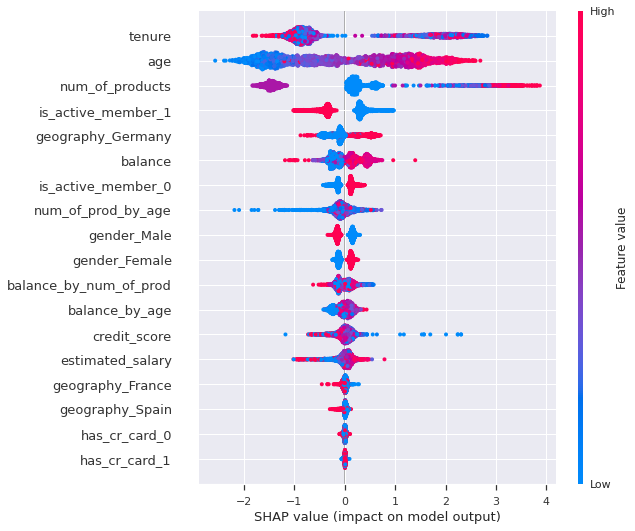

In [82]:
shap.summary_plot(shap_values, x_validation,show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

In [83]:
#features not selected
unimportant_cols = ['geography_France', 'has_cr_card_1', 'has_cr_card_0', 'geography_Spain']

# Drop uniportant attributes
X_train = X_train.drop(unimportant_cols, axis=1)

x_validation = x_validation.drop(unimportant_cols, axis=1)

#### Random Forest

In [84]:
# from BorutaShap import BorutaShap
# from catboost import CatBoostClassifier

# # https://www.youtube.com/watch?v=ZkIxZ5xlMuI

# # no model selected default is Random Forest, we will use a CatBoostClassifier. If classification is True it is a Classification problem.
# cat_boruta = RandomForestRegressor( n_jobs=-1 ,random_state=42)

# Feature_Selector_cat = BorutaShap(model = cat_boruta,
#                               importance_measure='shap',
#                               classification=True)

# Feature_Selector_cat.fit(X=X_train, y=y_train, n_trials=100, random_state=32)


# # Returns Boxplot of features
# Feature_Selector_cat.plot(X_size=12, figsize=(12,8),
#             y_scale='log', which_features='all')


#  # Drop uniportant attributes
# # X_train = X_train.drop(unimportant_cols, axis=1)

# # X_test = X_test.drop(unimportant_cols, axis=1)

# 7.0 MACHINE LEARNING


In [85]:
df7 = df6.copy()

## 7.1 Logistic regression

Advantages
- It's a simple model, so it takes very little time for training.
- It can handle a large number of features.


Disadvantages
- Although it has the word regression in its name, we can only use it for classification problems because of its range which always lies between 0 and 1.
- It can only be used for binary classification problems and has a poor response for multi-class classification problems

**logistic regression common hyperparameters:** penalty, max_iter, C, solver

https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27


In [86]:
# model definition and fit
model_lr=LogisticRegression(solver='liblinear',random_state=32).fit(X_train, y_train)

yhat_lr=model_lr.predict(x_validation)

# 1D array to generate score
# df7['score']=yhat_lr[:, 1].tolist()

# df7.sort_values('score', ascending=False).tail(20)

print("Acurácia Logistic Regression= ", accuracy_score(y_validation, yhat_lr))



Acurácia Logistic Regression=  0.7153170119271814


In [87]:
print(classification_report(y_validation, yhat_lr))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71      1593
           1       0.71      0.73      0.72      1593

    accuracy                           0.72      3186
   macro avg       0.72      0.72      0.72      3186
weighted avg       0.72      0.72      0.72      3186



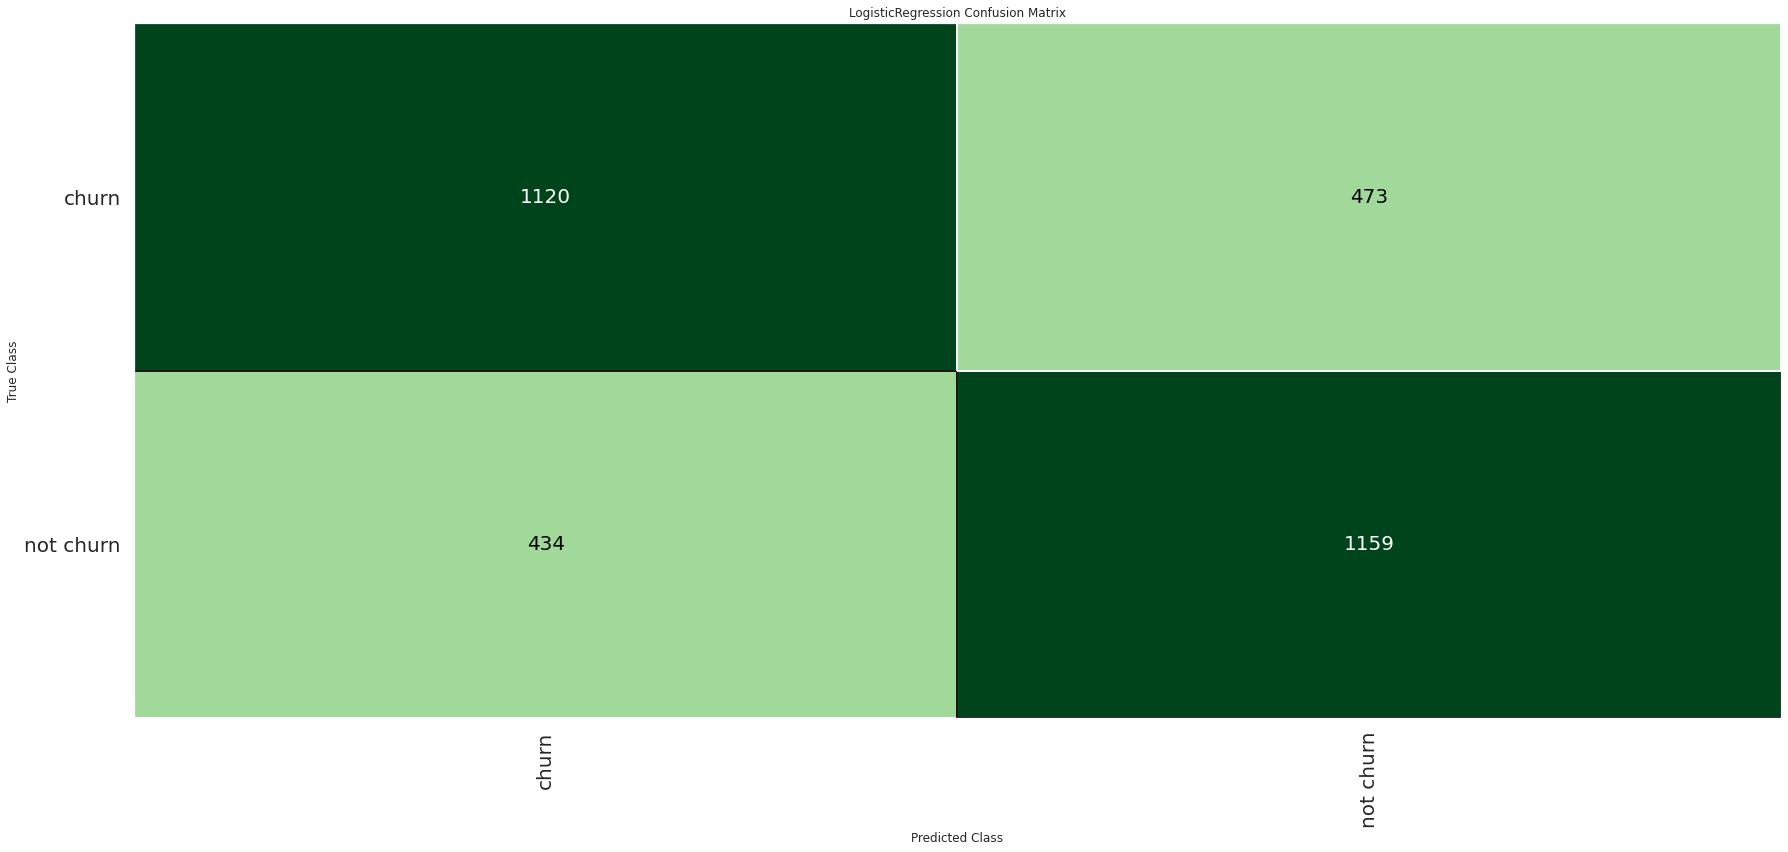

In [88]:

conf_mat = ConfusionMatrix(model_lr,  classes=['churn', 'not churn'], support=True, percent=False, cmap='Greens',fontsize=20)
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

## 7.2 Decision Tree

Advantages
- This algorithm allows for an uncomplicated representation of data. So, it is easier to interpret and explain it to executives.
- Decision Trees mimic the way humans make decisions in everyday life.
- They smoothly handle qualitative target variables.
- They handle non-linear data effectively.


Disadvantages
- They may create complex trees which sometimes become irrelevant.
- They do not have the same level of prediction accuracy as compared to other algorithms.

**decision tree common hyperparameters:** criterion, max_depth, min_samples_split, min_samples_leaf; max_features

https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680

In [89]:
from sklearn.tree import DecisionTreeClassifier
# model definition and fit
model_dtc= DecisionTreeClassifier(random_state=32).fit(X_train, y_train)

# predict
yhat_dtc=model_dtc.predict(x_validation)

print("Acurácia Decision Tree= ", accuracy_score(y_validation, yhat_dtc))


Acurácia Decision Tree=  0.8440050219711237


In [90]:
print(classification_report(y_validation, yhat_dtc))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1593
           1       0.84      0.85      0.84      1593

    accuracy                           0.84      3186
   macro avg       0.84      0.84      0.84      3186
weighted avg       0.84      0.84      0.84      3186



In [91]:
# from yellowbrick.classifier import ClassificationReport

# cr_viz = ClassificationReport(model_dtc,  classes=['not churn', 'churn'], support=False, cmap='Greens')
# cr_viz.fit(X_train, y_train)  
# cr_viz.score(x_validation, y_validation)
# cr_viz.finalize()

## 7.3 Random Forest

Advantages
- It is efficient when it comes to large datasets.
- It allows estimating the significance of input variables in classification.
- It is more accurate than decision trees.

Disadvantages
- It is more complex when it comes to implementation and thus takes more time to evaluate.

**random forest common hyperparameters:** n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, boostrap

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [92]:
from sklearn.ensemble import RandomForestClassifier

# model definition and fit
model_rf=RandomForestClassifier(random_state=32, n_jobs=-1).fit(X_train, y_train)

# predict
yhat_rf=model_rf.predict(x_validation)

print("Acurácia Random Forest= ", accuracy_score(y_validation, yhat_rf))


Acurácia Random Forest=  0.8826114249843063


In [93]:
print(classification_report(y_validation, yhat_rf))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1593
           1       0.89      0.87      0.88      1593

    accuracy                           0.88      3186
   macro avg       0.88      0.88      0.88      3186
weighted avg       0.88      0.88      0.88      3186



## 7.4 Support Vector Machine (SVM)

Advantages
- It makes training the dataset easy.
- It performs well when the data is high-dimensional.


Disadvantages
- It doesn't perform well when the data has noisy elements.
- It is sensitive to kernel functions, so they have to be chosen wisely.

support vector machine common hyperparameters: c, kernel, gamma

https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

In [94]:
from sklearn.svm import SVC

# model definition and fit
model_svm=SVC(random_state=32,probability=True).fit(X_train, y_train)

# predict
yhat_svm=model_svm.predict(x_validation)

print("Acurácia SVM = ", accuracy_score(y_validation, yhat_svm))


Acurácia SVM =  0.7711864406779662


In [95]:
print(classification_report(y_validation, yhat_svm))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1593
           1       0.79      0.73      0.76      1593

    accuracy                           0.77      3186
   macro avg       0.77      0.77      0.77      3186
weighted avg       0.77      0.77      0.77      3186



## 7.5 K-Nearest Neighbour (KNN Classifier)

Advantages
- One can apply it to datasets of any distribution.
- It is easy to understand and is quite intuitive.

Disadvantages
- It is easily affected by outliers.
- It is biased towards a class that has more instances in the dataset.
- It is sometimes challenging to find the optimal number for K.

KNN common hyperparameters: n_neighbors, weights, leaf_size, p

https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f?gi=6ace5ed01f38

In [96]:
from sklearn                   import neighbors          as nh

# model definition
model_knn = nh.KNeighborsClassifier( n_neighbors=10 ).fit( X_train, y_train )

# model prediction 
yhat_proba_knn = model_knn.predict( x_validation )

print("Acurácia KNN = ", accuracy_score(y_validation, yhat_proba_knn))


Acurácia KNN =  0.8101067168863779


In [97]:
print(classification_report(y_validation, yhat_proba_knn))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1593
           1       0.80      0.83      0.81      1593

    accuracy                           0.81      3186
   macro avg       0.81      0.81      0.81      3186
weighted avg       0.81      0.81      0.81      3186



## 7.6 Naive Bayes

Advantages
- It gives good results for complex real-world problems.
- The time required by the machine to learn the pattern using this classifier is less.
- It performs well in the case where the input variables have categorical values. (not this case)
- It performs well in the case of multi-class classification.(not this case)


Disadvantages


- It assumes independence among feature variables which may not always be the case.
- We often refer to it as a bad estimator, and hence the probabilities are not always of great significance.
- If, during the training time, the model was not aware of any of the categorical variables and that variable is passed during testing, the model assigns 0 (zero) likelihood and thus substitutes zero probability referred to as 'zero frequency.' One can avoid this situation by using smoothing procedures such as Laplace estimation.


**gaussian naive bayes common hyperparameters**: priors, var_smoothing

https://www.analyticsvidhya.com/blog/2021/01/gaussian-naive-bayes-with-hyperpameter-tuning/



In [98]:
from sklearn.naive_bayes import GaussianNB

# model definition and train
model_gnb= GaussianNB().fit(X_train, y_train)

# predict
yhat_gnb= model_gnb.predict(x_validation)

print("Acurácia Naive Bayes = ", accuracy_score(y_validation, yhat_gnb))


Acurácia Naive Bayes =  0.7338355304456999


In [99]:
print(classification_report(y_validation, yhat_gnb))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1593
           1       0.73      0.74      0.74      1593

    accuracy                           0.73      3186
   macro avg       0.73      0.73      0.73      3186
weighted avg       0.73      0.73      0.73      3186



## 7.7 XGBoost

In [100]:
import xgboost                 as xgb

# model definition and fit
model_xgb = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, eval_metric='logloss').fit(X_train, y_train)


# prediction
yhat_xgb = model_xgb.predict(x_validation)

print("Acurácia XGBoost = ", accuracy_score(y_validation, yhat_xgb))


Acurácia XGBoost =  0.9033270558694287


In [101]:
print(classification_report(y_validation, yhat_xgb))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      1593
           1       0.93      0.88      0.90      1593

    accuracy                           0.90      3186
   macro avg       0.90      0.90      0.90      3186
weighted avg       0.90      0.90      0.90      3186



## 7.8 Catboost

In [102]:
# model definition and fit
model_cat = CatBoostClassifier(random_seed=32, logging_level='Silent').fit(X_train, y_train)

# prediction
yhat_cat=model_cat.predict(x_validation)

print("Acurácia CatBoost = ", accuracy_score(y_validation, yhat_cat))

Acurácia CatBoost =  0.903954802259887


In [103]:

print(classification_report(y_validation, yhat_cat))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1593
           1       0.93      0.87      0.90      1593

    accuracy                           0.90      3186
   macro avg       0.91      0.90      0.90      3186
weighted avg       0.91      0.90      0.90      3186



## 7.9 Models Comparison

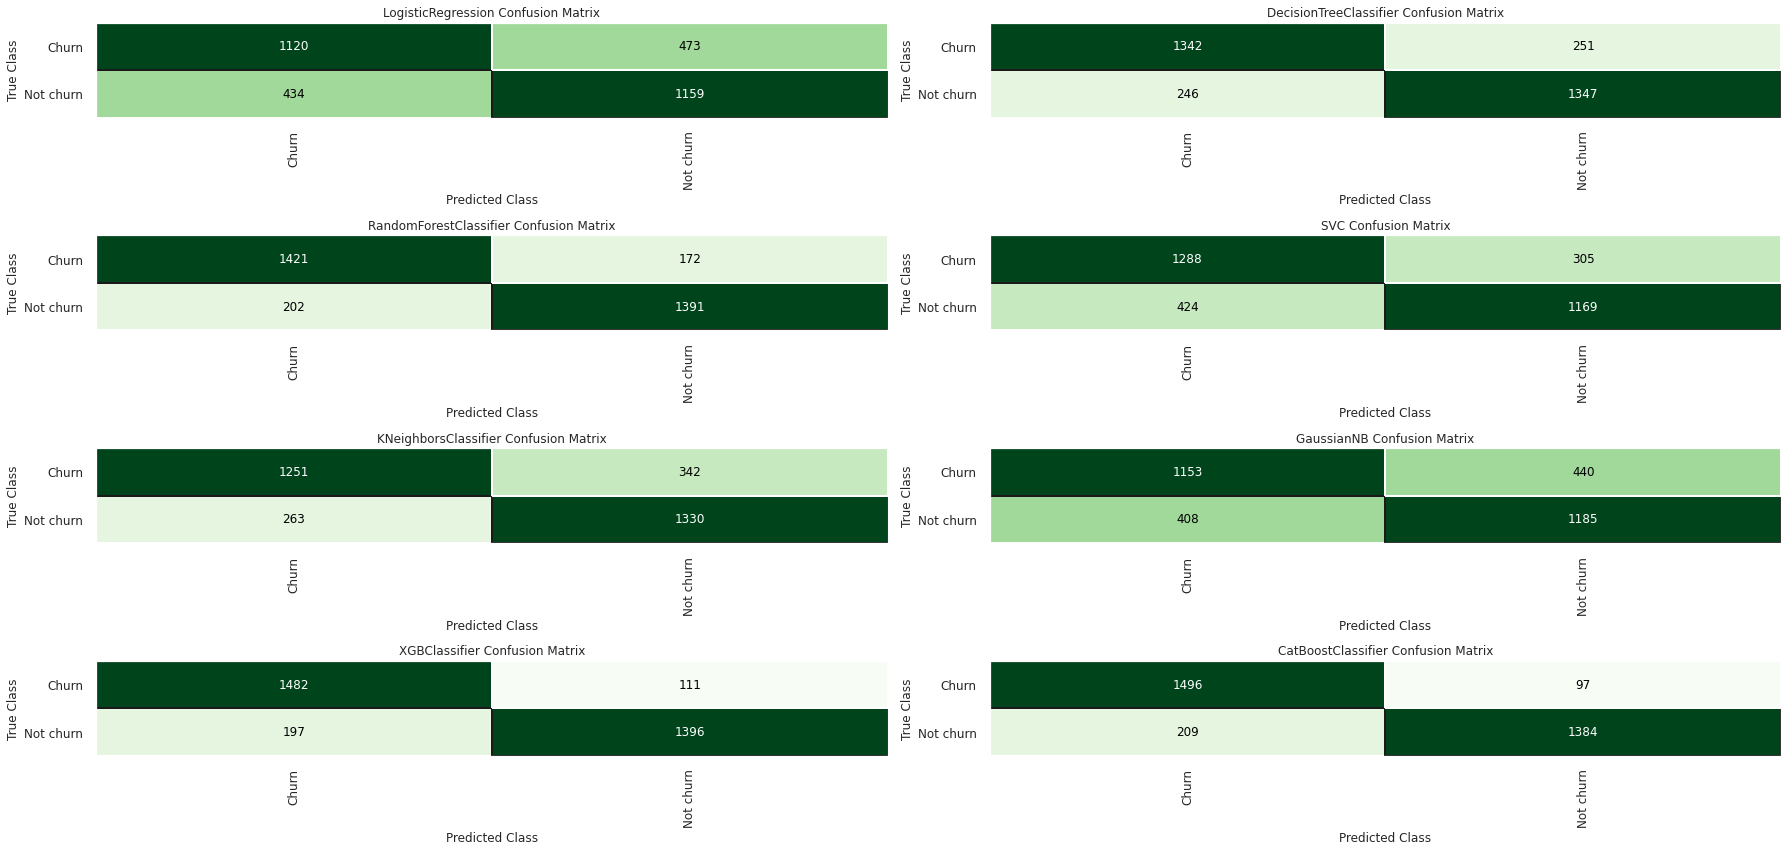

In [104]:
from yellowbrick.contrib.wrapper import wrap

plt.title('Comparasion Between All Models')

plt.subplot(4,2,1)
conf_mat = ConfusionMatrix(model_lr,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,2)
conf_mat = ConfusionMatrix (model_dtc,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,3)
conf_mat = ConfusionMatrix (model_rf,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,4)
conf_mat = ConfusionMatrix(model_svm ,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,5)
conf_mat = ConfusionMatrix(model_knn ,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,6)
conf_mat = ConfusionMatrix(model_gnb ,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,7)
conf_mat = ConfusionMatrix(model_xgb ,  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()

plt.subplot(4,2,8)
conf_mat = ConfusionMatrix(wrap(model_cat),  classes=['Churn', 'Not churn'], support=True, cmap='Greens')
conf_mat.fit(X_train, y_train)  
conf_mat.score(x_validation, y_validation)
conf_mat.finalize()
plt.show()

# 8.0. HYPERPARAMETER FINE TUNING

In [105]:
df8 = df7.copy()

## 8.1 XGB TUNING

### 7. Real Performance - Cross Validation

# 9.0 Business Performance

In [106]:
df9 = df8.copy

# 10.0 Deploy to Production